<a href="https://colab.research.google.com/github/skyshine460/ProdTaken/blob/main/ProdTaken_lightgbm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [114]:
train_df = pd.read_csv('/content/drive/MyDrive/契約予測（SIGNATE Cup 2024）/提供データ/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/契約予測（SIGNATE Cup 2024）/提供データ/test.csv')

# データの整理

目的変数：ProdTaken（商品の契約状態(0:不成約、1:成約)）


評価指標：AUC

In [115]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(f'(index, col) : {df.shape}')
    return info_df

In [116]:
information_df(train_df)

(index, col) : (3489, 18)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,3489,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
Age,object,100,237,"[50歳, 56歳, nan, 三十七歳, 48歳, 19歳, 47歳, 49歳, 33歳,..."
TypeofContact,object,6,2,"[Self Enquiry, Company Invited, nan]"
CityTier,int64,0,3,"[2, 1, 3]"
DurationOfPitch,object,121,65,"[900秒, 14分, 10分, 1080秒, 1020秒, 16分, 840秒, 22分,..."
Occupation,object,0,3,"[Large Business, Salaried, Small Business]"
Gender,object,0,18,"[male, Male, Female, female, ｆｅｍａｌｅ, FEMALE, Ｍ..."
NumberOfPersonVisiting,float64,0,4,"[1.0, 2.0, 3.0, 4.0]"
NumberOfFollowups,float64,33,11,"[4.0, 3.0, 5.0, 1.0, 2.0, 100.0, nan, 500.0, 4..."
ProductPitched,object,0,76,"[Basic, Standard, Super Deluxe, basic, SUPER D..."


In [117]:
information_df(test_df)

(index, col) : (3489, 17)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,3489,"[3489, 3490, 3491, 3492, 3493, 3494, 3495, 349..."
Age,object,93,236,"[４８歳, 30代, 25歳, 21歳, 41歳, 45歳, 44才, 30際, 31際, ..."
TypeofContact,object,12,2,"[Self Enquiry, Company Invited, nan]"
CityTier,int64,0,3,"[2, 1, 3]"
DurationOfPitch,object,131,65,"[13分, 12分, 540秒, 420秒, 7分, nan, 8分, 16分, 22分, ..."
Occupation,object,0,3,"[Small Business, Salaried, Large Business]"
Gender,object,0,17,"[Male, Ｆｅｍａｌｅ, Female, MALE, male, ｍａｌｅ, Ｍａｌｅ,..."
NumberOfPersonVisiting,float64,0,4,"[1.0, 2.0, 3.0, 4.0]"
NumberOfFollowups,float64,24,11,"[4.0, 3.0, 300.0, 5.0, 400.0, 1.0, 2.0, 6.0, 1..."
ProductPitched,object,0,71,"[Super De|uxe, Standard, Basic, Deluxe, Super ..."


# EDA


In [118]:
def plot_histograms(train_df, col, bins=100):
    target = 'ProdTaken'

    bins = np.linspace(train_df[col].min(), train_df[col].max(), bins)

    data_all = train_df[col]
    data_ProdTaken_0 = train_df[train_df[target] == 0][col]
    data_ProdTaken_1 = train_df[train_df[target] == 1][col]

    plt.figure(figsize=(12, 6))
    plt.hist(data_all, bins=bins, alpha=0.5, color='green', label='All Data', density=False, edgecolor='black')
    plt.hist(data_ProdTaken_0, bins=bins, alpha=0.5, color='blue', label='ProdTaken: 0', density=False, edgecolor='black')
    plt.hist(data_ProdTaken_1, bins=bins, alpha=0.5, color='orange', label='ProdTaken: 1', density=False, edgecolor='black')

    plt.xlim(train_df[col].min(), train_df[col].max())
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col} by ProdTaken')
    plt.legend()
    plt.show()

def barplots(train_df, col):
    target = 'ProdTaken'

    unique_values = train_df[col].nunique()
    counts_ProdTaken_0 = train_df[train_df[target] == 0][col].value_counts().sort_index()
    counts_ProdTaken_1 = train_df[train_df[target] == 1][col].value_counts().sort_index()

    bar_width = 0.35
    indices = np.arange(len(counts_ProdTaken_0))

    plt.figure(figsize=(8, 6))
    plt.bar(indices, counts_ProdTaken_0, bar_width, label='ProdTaken: 0', color='blue', edgecolor='black')
    plt.bar(indices + bar_width, counts_ProdTaken_1, bar_width, label='ProdTaken: 1', color='orange', edgecolor='black')

    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Bar Chart of {col} by ProdTaken')
    plt.xticks(indices + bar_width / 2, counts_ProdTaken_0.index)
    plt.legend()
    plt.show()

def crosstab_df(col):
    crosstab = pd.crosstab(train_df[col], train_df['ProdTaken'])
    crosstab['ProdTaken_1_ratio'] = crosstab[1] / (crosstab[0] + crosstab[1])
    return crosstab

def category_and_category(col1, col2):
    train_df[col1+"_"+col2] = train_df[col1].astype(str) + '_' + train_df[col2].astype(str)
    train_df[col1+"_"+col2] = train_df[col1+"_"+col2].astype('category')
    test_df[col1+"_"+col2] = test_df[col1].astype(str) + '_' + test_df[col2].astype(str)
    test_df[col1+"_"+col2] = test_df[col1+"_"+col2].astype('category')

# Age

In [119]:
train_df['Age'] = train_df['Age'].replace('', np.nan)  # Replace empty strings with NaN
train_df['Age'] = train_df['Age'].str.replace('[歳才際]', '', regex=True)  # Remove "歳" or "才" or "歳"

def convert_full_width_to_half_width(text): # 半角全角の変換
    if isinstance(text, str):
        table = str.maketrans('０１２３４５６７８９', '0123456789')
        return text.translate(table)
    return text
train_df['Age'] = train_df['Age'].apply(convert_full_width_to_half_width)

age_generations = { #年代の変換
    '20代': 29, '30代': 36, '40代': 41, '50代': 52, '60代': 60,
    '２０代': 29, '３０代': 36, '４０代': 41, '５０代': 52, '６０代': 60,
}
train_df['Age'] = train_df['Age'].replace(age_generations, regex=True)

# 修正された漢数字変換関数
def convert_kansuuji_to_arabic_number(kansuuji):
    # 漢数字変換表
    convert_table = str.maketrans("一二三四五六七八九", "123456789")
    unit_under_thousand = {"十": 1, "百": 2, "千": 3}

    if not isinstance(kansuuji, str):
        return kansuuji  # 文字列でない場合はそのまま返す

    arabic_number = ''
    base_unit = 0
    reversed_kansuuji = list(reversed(kansuuji))

    for i, character in enumerate(reversed_kansuuji):
        if character in unit_under_thousand:  # 単位の処理
            arabic_number = arabic_number.zfill(unit_under_thousand[character] + base_unit)
            if i == len(reversed_kansuuji) - 1 or reversed_kansuuji[i+1] in unit_under_thousand:
                arabic_number = '1' + arabic_number
        else:  # 一〜九の処理
            arabic_number = character.translate(convert_table) + arabic_number

    return arabic_number

# 漢数字の変換を行う
train_df['Age'] = train_df['Age'].apply(lambda x: convert_kansuuji_to_arabic_number(x) if isinstance(x, str) else x)

# 漢数字変換後に数値型に変換
train_df['Age'] = pd.to_numeric(train_df['Age'], errors='coerce').astype('Int64')
# train_df['Age'].value_counts()

In [120]:
test_df['Age'] = test_df['Age'].replace('', np.nan)  # Replace empty strings with NaN
test_df['Age'] = test_df['Age'].str.replace('[歳才際]', '', regex=True)  # Remove "歳" or "才" or "歳"

def convert_full_width_to_half_width(text): # 半角全角の変換
    if isinstance(text, str):
        table = str.maketrans('０１２３４５６７８９', '0123456789')
        return text.translate(table)
    return text
test_df['Age'] = test_df['Age'].apply(convert_full_width_to_half_width)

age_generations = { #年代の変換
    '20代': 29, '30代': 36, '40代': 41, '50代': 52, '60代': 60,
    '２０代': 29, '３０代': 36, '４０代': 41, '５０代': 52, '６０代': 60,
}
test_df['Age'] = test_df['Age'].replace(age_generations, regex=True)

# 修正された漢数字変換関数
def convert_kansuuji_to_arabic_number(kansuuji):
    # 漢数字変換表
    convert_table = str.maketrans("一二三四五六七八九", "123456789")
    unit_under_thousand = {"十": 1, "百": 2, "千": 3}

    if not isinstance(kansuuji, str):
        return kansuuji  # 文字列でない場合はそのまま返す

    arabic_number = ''
    base_unit = 0
    reversed_kansuuji = list(reversed(kansuuji))

    for i, character in enumerate(reversed_kansuuji):
        if character in unit_under_thousand:  # 単位の処理
            arabic_number = arabic_number.zfill(unit_under_thousand[character] + base_unit)
            if i == len(reversed_kansuuji) - 1 or reversed_kansuuji[i+1] in unit_under_thousand:
                arabic_number = '1' + arabic_number
        else:  # 一〜九の処理
            arabic_number = character.translate(convert_table) + arabic_number

    return arabic_number

# 漢数字の変換を行う
test_df['Age'] = test_df['Age'].apply(lambda x: convert_kansuuji_to_arabic_number(x) if isinstance(x, str) else x)

# 漢数字変換後に数値型に変換
test_df['Age'] = pd.to_numeric(test_df['Age'], errors='coerce').astype('Int64')
# test_df['Age'].value_counts()

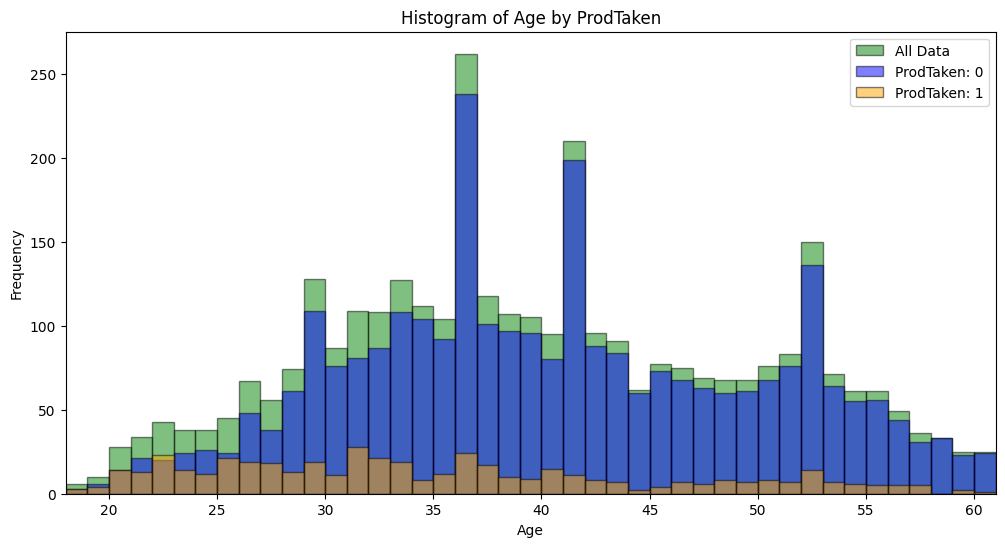

In [121]:
plot_histograms(train_df, 'Age', bins=44)

In [122]:
crosstab_df('Age')

ProdTaken,0,1,ProdTaken_1_ratio
Age,,,
18,3,3,0.500000
19,6,4,0.400000
20,14,14,0.500000
21,21,13,0.382353
22,20,23,0.534884
23,24,14,0.368421
24,26,12,0.315789
25,24,21,0.466667
26,48,19,0.283582


In [123]:
def age_fillna(df):
    df['Age'] = df['Age'].fillna(df['Age'].median())
    return df

train_df = age_fillna(train_df)
test_df = age_fillna(test_df)

# TypeofContact

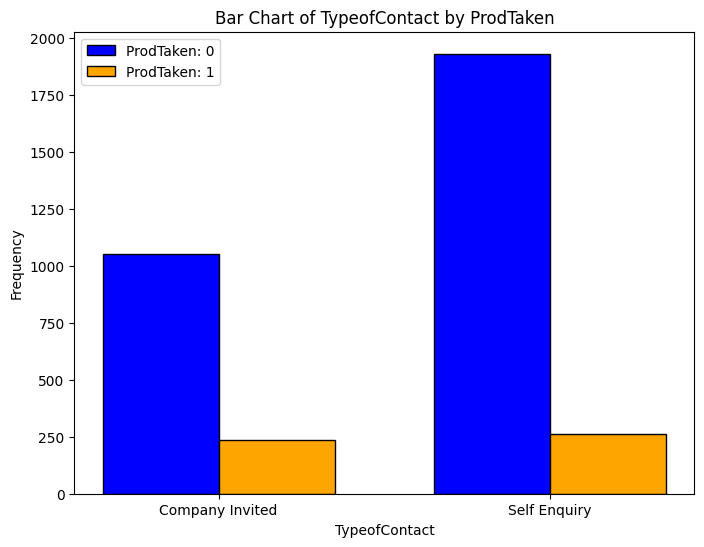

ProdTaken,0,1,ProdTaken_1_ratio
TypeofContact,,,
Company Invited,1054,235,0.182312
Self Enquiry,1932,262,0.119417


In [124]:
# TypeofContact
barplots(train_df, 'TypeofContact')
crosstab_df('TypeofContact')

In [125]:
def TypeofContact_eda(df):
    df['TypeofContact'] = df['TypeofContact'].fillna('Self Enquiry')
    map = {
        'Company Invited': 0,
        'Self Enquiry': 1
    }
    df['TypeofContact'] = df['TypeofContact'].map(map)
    return df

train_df = TypeofContact_eda(train_df)
test_df = TypeofContact_eda(test_df)
crosstab_df('TypeofContact')

ProdTaken,0,1,ProdTaken_1_ratio
TypeofContact,,,
0,1054,235,0.182312
1,1938,262,0.119091


# CityTier

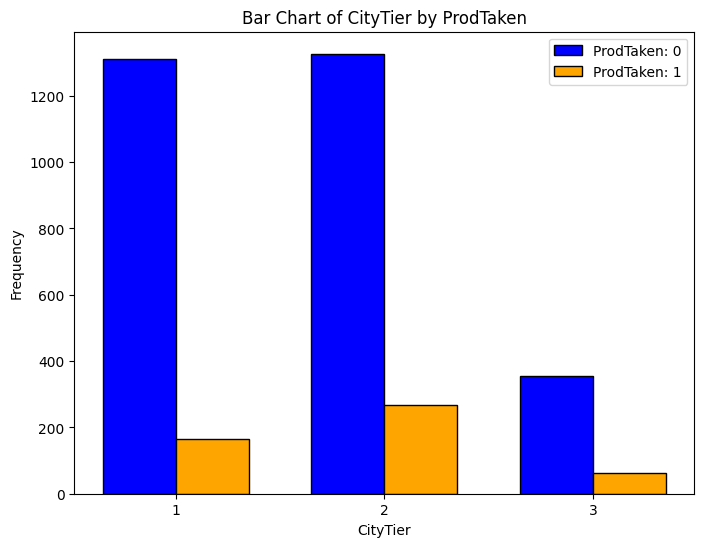

ProdTaken,0,1,ProdTaken_1_ratio
CityTier,,,
1,1310,165,0.111864
2,1327,269,0.168546
3,355,63,0.150718


In [126]:
barplots(train_df, 'CityTier')
crosstab_df('CityTier')

In [127]:
def onehot_encoded(train_df, col):
  # One-Hot エンコーディング
  df_onehot = pd.get_dummies(train_df[col], prefix=col, drop_first=False)
  df_onehot = df_onehot.astype(int)

  # 新しいカラムとして追加
  train_df = pd.concat([train_df, df_onehot], axis=1)
  return train_df

train_df = onehot_encoded(train_df, 'CityTier')
test_df = onehot_encoded(test_df, 'CityTier')

In [128]:
train_df.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken,CityTier_1,CityTier_2,CityTier_3
0,0,50,1,2,900秒,Large Business,male,1.0,4.0,Basic,...,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1,0,1,0
1,1,56,0,1,14分,Salaried,Male,1.0,4.0,Standard,...,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0,1,0,0
2,2,38,1,1,10分,Large Business,Female,1.0,3.0,Basic,...,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1,1,0,0
3,3,37,1,2,1080秒,Small Business,female,1.0,3.0,Standard,...,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0,0,1,0
4,4,48,0,3,1020秒,Small Business,female,1.0,3.0,Basic,...,4,0,4,Executive,258435.0,独身／車所持／無子,1,0,0,1


# DurationOfPitch

In [129]:
train_df['DurationOfPitch'].value_counts()

,count
DurationOfPitch,
8分,259
9分,237
15分,216
14分,207
16分,202
10分,181
7分,170
13分,150
11分,113


In [130]:
# 秒と分を処理して新しいカラムを作成
def convert_duration(duration):
    if isinstance(duration, str):  # 文字列型であることを確認
        if '秒' in duration:
            return int(duration.replace('秒', '')), int(duration.replace('秒', '')) / 60
        elif '分' in duration:
            return int(duration.replace('分', '')) * 60, int(duration.replace('分', ''))
    return np.nan, np.nan  # その他の場合は NaN を返す

train_df['DurationOfPitch_sec'], train_df['DurationOfPitch_min'] = zip(*train_df['DurationOfPitch'].apply(convert_duration))
test_df['DurationOfPitch_sec'], test_df['DurationOfPitch_min'] = zip(*test_df['DurationOfPitch'].apply(convert_duration))
train_df[['DurationOfPitch', 'DurationOfPitch_sec', 'DurationOfPitch_min']].head()

,DurationOfPitch,DurationOfPitch_sec,DurationOfPitch_min
0,900秒,900.0,15.0
1,14分,840.0,14.0
2,10分,600.0,10.0
3,1080秒,1080.0,18.0
4,1020秒,1020.0,17.0


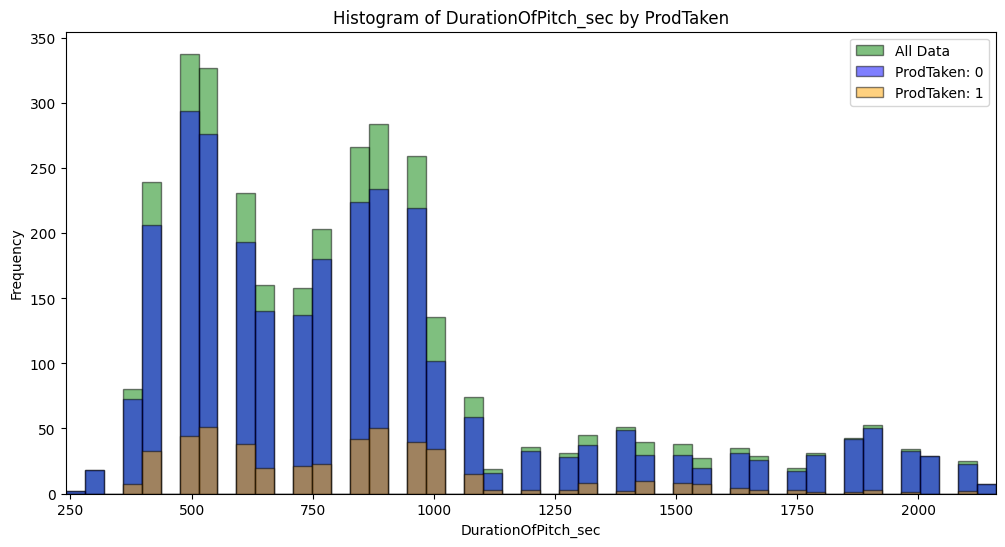

In [131]:
plot_histograms(train_df, 'DurationOfPitch_sec', bins=50)

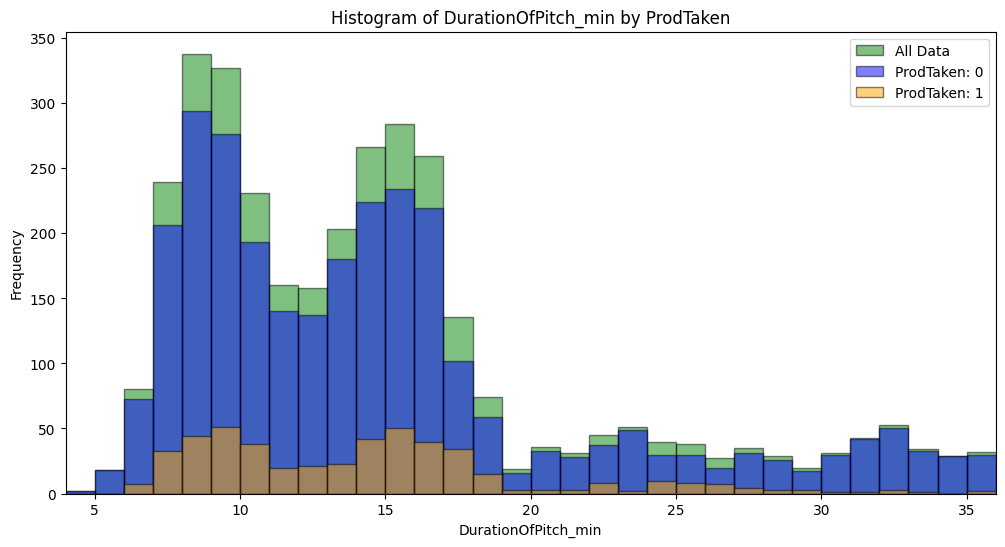

In [132]:
plot_histograms(train_df, 'DurationOfPitch_min', bins=33)

In [133]:
bins = [0, 10, 15, 20, 25, 30, 40]
labels = ['0-9', '10-14', '15-19', '20-24', '25-29', '30-40']

train_df['DurationOfPitch_group'] = pd.cut(train_df['DurationOfPitch_min'], bins=bins, labels=labels, right=False)
test_df['DurationOfPitch_group'] = pd.cut(test_df['DurationOfPitch_min'], bins=bins, labels=labels, right=False)

crosstab_df('DurationOfPitch_group')

ProdTaken,0,1,ProdTaken_1_ratio
DurationOfPitch_group,,,
0-9,869,135,0.134462
10-14,874,144,0.141454
15-19,630,142,0.183938
20-24,177,26,0.128079
25-29,124,25,0.167785
30-40,214,8,0.036036


# Occupation

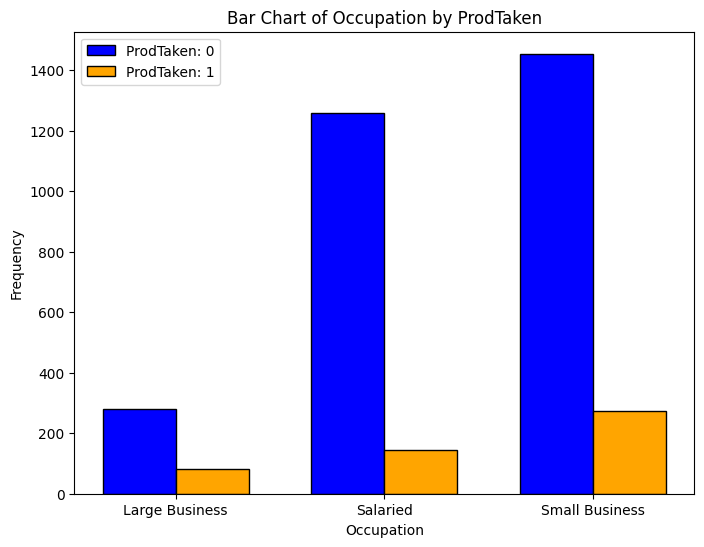

ProdTaken,0,1,ProdTaken_1_ratio
Occupation,,,
Large Business,279,82,0.227147
Salaried,1258,143,0.102070
Small Business,1455,272,0.157499


In [134]:
barplots(train_df, 'Occupation')
crosstab_df('Occupation')

In [135]:
train_df = onehot_encoded(train_df, 'Occupation')
test_df = onehot_encoded(test_df, 'Occupation')

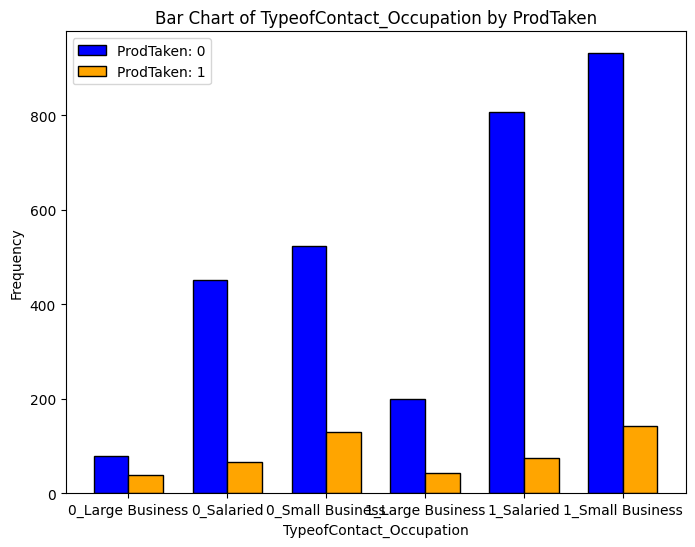

ProdTaken,0,1,ProdTaken_1_ratio
TypeofContact_Occupation,,,
0_Large Business,79,38,0.324786
0_Salaried,451,67,0.129344
0_Small Business,524,130,0.198777
1_Large Business,200,44,0.180328
1_Salaried,807,76,0.086070
1_Small Business,931,142,0.132339


In [136]:
category_and_category('TypeofContact', 'Occupation')
barplots(train_df, 'TypeofContact_Occupation')
crosstab_df('TypeofContact_Occupation')

# Gender

In [137]:
train_df['Gender'].value_counts()

,count
Gender,
Male,1226
Female,739
male,468
female,266
MALE,183
Ｍａｌｅ,126
Fe Male,109
FEMALE,99
Ｆｅｍａｌｅ,89


In [138]:
def Gender_eda(train_df):
    male_words = ['Male', 'male', 'MALE', 'Ｍａｌｅ', 'ｍａｌｅ', 'ＭＡＬＥ']
    female_words = ['Female', 'female', 'Fe Male', 'FEMALE', 'Ｆｅｍａｌｅ', 'ｆｅｍａｌｅ', 'fe male', 'FE MALE', 'ＦＥＭＡＬＥ', 'Ｆｅ　Ｍａｌｅ', 'ｆｅ　ｍａｌｅ', 'ＦＥ　ＭＡＬＥ']
    train_df['Gender'] = train_df['Gender'].apply(lambda x: 'Male' if x in male_words else ('Female' if x in female_words else x))

    map = {
        'Male': 0,
        'Female': 1
    }
    train_df['Gender'] = train_df['Gender'].map(map)
    return train_df

train_df = Gender_eda(train_df)
test_df = Gender_eda(test_df)

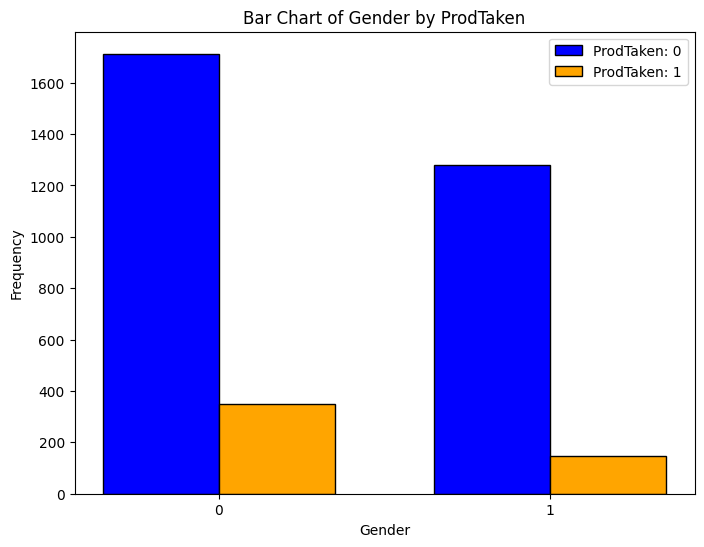

ProdTaken,0,1,ProdTaken_1_ratio
Gender,,,
0,1713,351,0.170058
1,1279,146,0.102456


In [139]:
barplots(train_df, 'Gender')
crosstab_df('Gender')

# NumberOfPersonVisiting

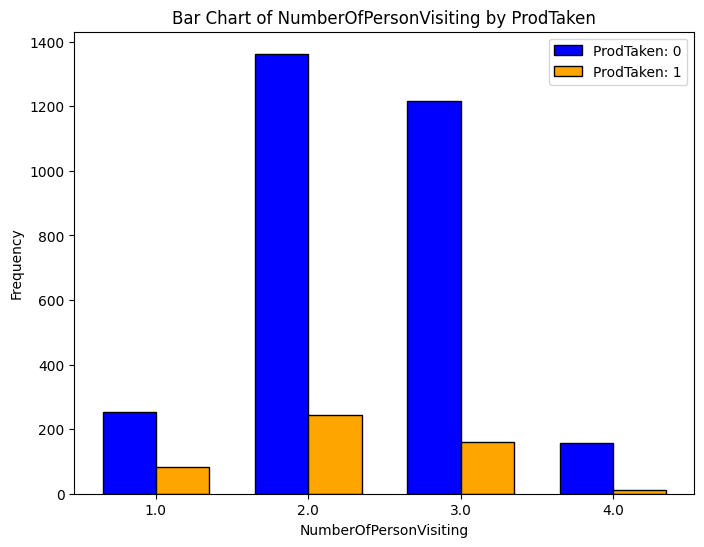

ProdTaken,0,1,ProdTaken_1_ratio
NumberOfPersonVisiting,,,
1.0,253,83,0.247024
2.0,1363,245,0.152363
3.0,1218,159,0.115468
4.0,158,10,0.059524


In [140]:
barplots(train_df, 'NumberOfPersonVisiting')
crosstab_df('NumberOfPersonVisiting')

# NumberOfFollowups

In [141]:
train_df['NumberOfFollowups'].value_counts()

,count
NumberOfFollowups,
4.0,1396
3.0,1279
5.0,519
2.0,108
1.0,77
6.0,38
300.0,17
400.0,15
500.0,5


In [142]:
test_df['NumberOfFollowups'].value_counts()

,count
NumberOfFollowups,
4.0,1350
3.0,1257
5.0,594
2.0,104
1.0,99
6.0,31
400.0,16
300.0,8
500.0,4


In [143]:
def NumberOfFollowups_eda(df):
    df['NumberOfFollowups'] = df['NumberOfFollowups'].replace(100, 1)
    df['NumberOfFollowups'] = df['NumberOfFollowups'].replace(200, 2)
    df['NumberOfFollowups'] = df['NumberOfFollowups'].replace(300, 3)
    df['NumberOfFollowups'] = df['NumberOfFollowups'].replace(400, 4)
    df['NumberOfFollowups'] = df['NumberOfFollowups'].replace(500, 5)
    df['NumberOfFollowups'] = df['NumberOfFollowups'].replace(600, 6)

    df['NumberOfFollowups'] = df['NumberOfFollowups'].fillna(df['NumberOfFollowups'].median())

    return df

train_df = NumberOfFollowups_eda(train_df)
test_df = NumberOfFollowups_eda(test_df)

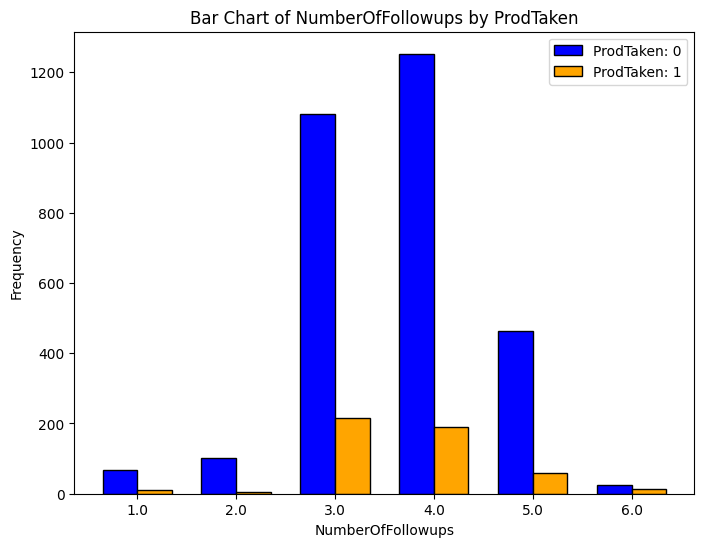

ProdTaken,0,1,ProdTaken_1_ratio
NumberOfFollowups,,,
1.0,68,10,0.128205
2.0,102,6,0.055556
3.0,1080,216,0.166667
4.0,1253,191,0.132271
5.0,464,60,0.114504
6.0,25,14,0.358974


In [144]:
barplots(train_df, 'NumberOfFollowups')
crosstab_df('NumberOfFollowups')

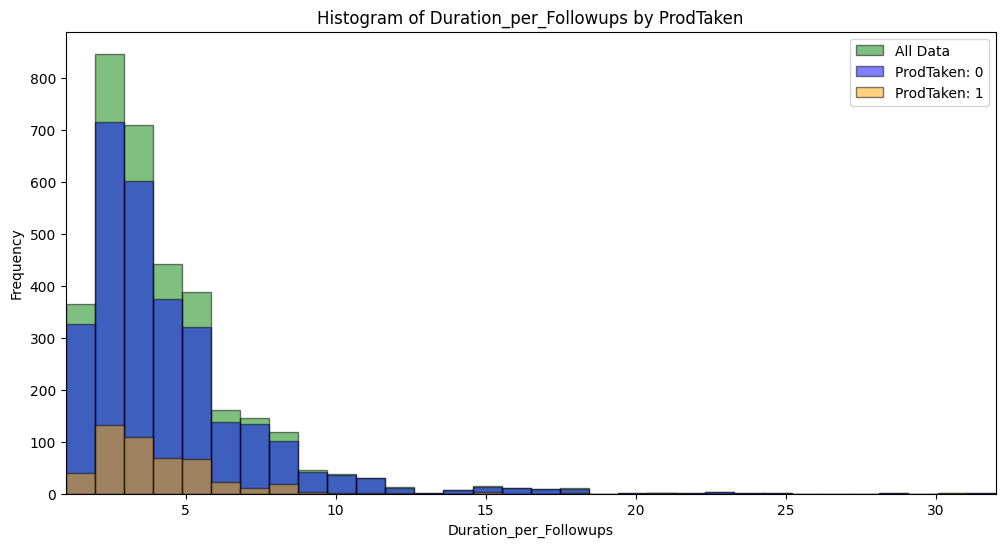

In [145]:
train_df['Duration_per_Followups'] = train_df['DurationOfPitch_min'] / train_df['NumberOfFollowups']
test_df['Duration_per_Followups'] = test_df['DurationOfPitch_min'] / test_df['NumberOfFollowups']

plot_histograms(train_df, 'Duration_per_Followups', bins=33)

# ProductPitched

In [146]:
train_df['ProductPitched'].value_counts()

,count
ProductPitched,
Basic,887
Deluxe,836
Standard,648
Super Deluxe,238
basic,106
BASIC,104
DELUXE,93
King,91
deluxe,88


In [147]:
test_df['ProductPitched'].value_counts()

,count
ProductPitched,
Basic,923
Deluxe,824
Standard,591
Super Deluxe,233
King,126
basic,112
BASIC,108
DELUXE,98
deluxe,91


In [148]:
basic_words = ['Basic', 'basic', 'BASIC', 'Basıc', 'Βasic', 'Basi𝘤', 'Вasic', '𐊡asic', 'Basiс', 'Basiϲ', 'B𝖺sic', '𐊡asi𝘤', 'Basıϲ', 'Βasıc', 'BASIС', 'B𝖺si𝘤', 'ΒASIС', 'basiϲ', 'В𝖺sic', 'BAꓢIC', 'BAՏIC', 'BΑSIC', 'Βası𝘤', 'BASΙC', 'Baｓic', 'basıc', 'BASΙС', 'Bası𝘤', 'baｓic', 'basi𝘤', 'Baｓıc', 'basiс', 'BAЅIC']
standard_words = ['Standard', 'standard', 'STANDARD', 'Stand𝖺rd', 'Տtandard', 'Staոdard', 'Standa𝘳d', 'S𝘵andard', 'Standar𝔡', 'St𝖺ndard', 'ꓢtandard', 'staոdard', 'Ѕtandard', 'Տtanda𝘳d', 'STANᗞARD', 'STANDARᎠ', 'ЅTANDARD', 'Stan𝔡ard', 'STΑNDARD', 'stan𝔡ard', 'standar𝔡', 'stand𝖺rd', 'S𝘵𝖺nda𝘳d', 'Stand𝖺𝘳d']
deluxe_words = ['DELUXE', 'deluxe', 'De|uxe', 'Delu×e', 'ᗞeluxe', '𝙳eluxe', 'DELUXΕ', 'Ꭰeluxe', 'ᎠELUXE', 'de|uxe', 'DΕLUXΕ', 'de|u×e', 'ᗞELUXE', 'Ꭰe|uxe']
superdeluxe_words = ['Super Deluxe', 'super deluxe', 'SUPER DELUXE', 'Super De|uxe', 'Super ᗞeluxe', 'Super Ꭰeluxe', 'ꓢuper Deluxe', 'Ѕuper Deluxe', 'Super 𝙳eluxe', 'SUPER DΕLUXE', 'ꓢuper De|uxe', 'Տuper Deluxe', 'super de|uxe', 'ｓuper deluxe', 'SUPΕR ᎠELUXE', 'Super Delu×e', 'SUPER ᗞELUXE', 'SUPER ᎠELUXE']
king_words = ['King', 'KING', 'king', 'Kıոg', 'Kiոg', 'Kıng', 'kiոg']

train_df['ProductPitched'] = train_df['ProductPitched'].apply(lambda x: 'Basic' if x in basic_words else ('Standard' if x in standard_words else ('Deluxe' if x in deluxe_words else ('Super Deluxe' if x in superdeluxe_words else ('King' if x in king_words else x)))))
test_df['ProductPitched'] = test_df['ProductPitched'].apply(lambda x: 'Basic' if x in basic_words else ('Standard' if x in standard_words else ('Deluxe' if x in deluxe_words else ('Super Deluxe' if x in superdeluxe_words else ('King' if x in king_words else x)))))

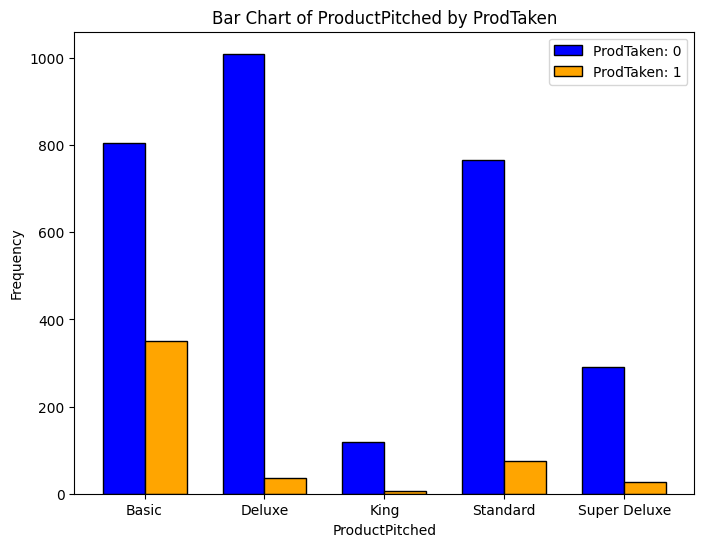

ProdTaken,0,1,ProdTaken_1_ratio
ProductPitched,,,
Basic,806,351,0.303371
Deluxe,1010,35,0.033493
King,119,7,0.055556
Standard,765,76,0.090369
Super Deluxe,292,28,0.087500


In [149]:
barplots(train_df, 'ProductPitched')
crosstab_df('ProductPitched')

In [150]:
train_df = onehot_encoded(train_df, 'ProductPitched')
test_df = onehot_encoded(test_df, 'ProductPitched')

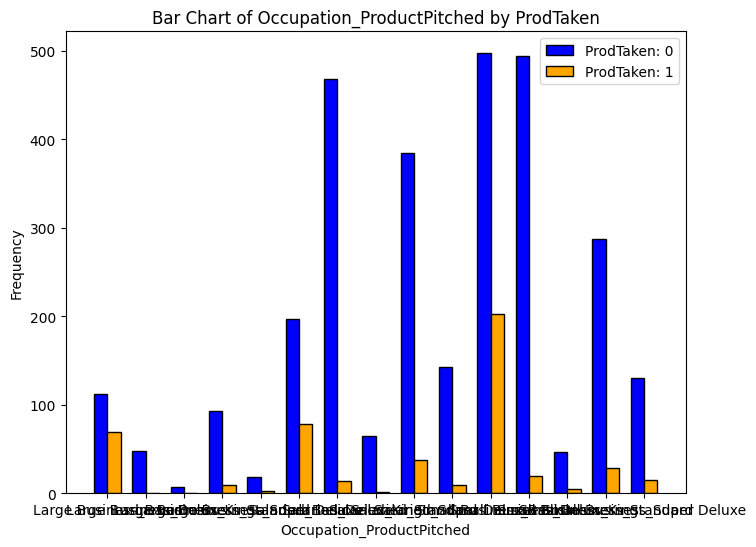

ProdTaken,0,1,ProdTaken_1_ratio
Occupation_ProductPitched,,,
Large Business_Basic,112,69,0.381215
Large Business_Deluxe,48,1,0.020408
Large Business_King,7,0,0.000000
Large Business_Standard,93,9,0.088235
Large Business_Super Deluxe,19,3,0.136364
Salaried_Basic,197,79,0.286232
Salaried_Deluxe,468,14,0.029046
Salaried_King,65,2,0.029851
Salaried_Standard,385,38,0.089835


In [151]:
category_and_category('Occupation', 'ProductPitched')
barplots(train_df, 'Occupation_ProductPitched')
crosstab_df('Occupation_ProductPitched')

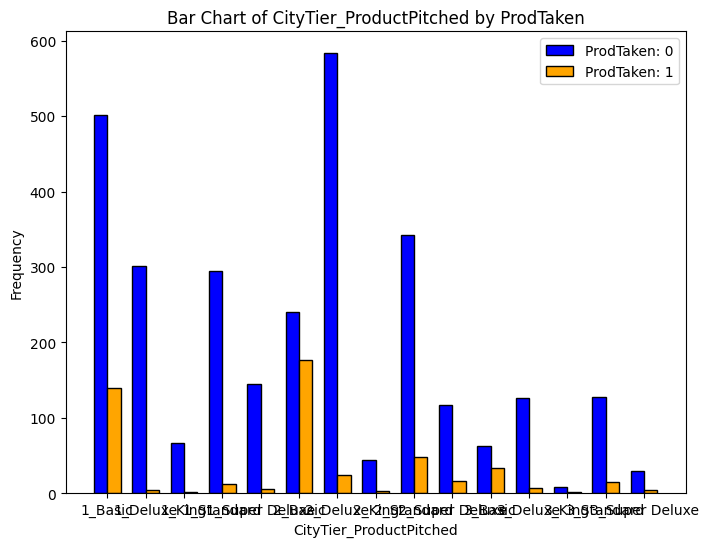

ProdTaken,0,1,ProdTaken_1_ratio
CityTier_ProductPitched,,,
1_Basic,502,140,0.218069
1_Deluxe,301,4,0.013115
1_King,67,2,0.028986
1_Standard,295,13,0.042208
1_Super Deluxe,145,6,0.039735
2_Basic,241,177,0.423445
2_Deluxe,583,24,0.039539
2_King,44,3,0.063830
2_Standard,342,48,0.123077


In [152]:
category_and_category('CityTier', 'ProductPitched')
barplots(train_df, 'CityTier_ProductPitched')
crosstab_df('CityTier_ProductPitched')

# PreferredPropertyStar

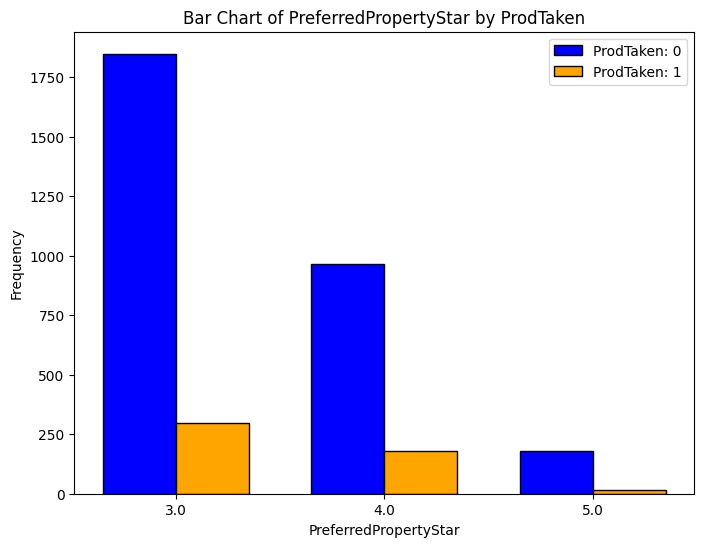

ProdTaken,0,1,ProdTaken_1_ratio
PreferredPropertyStar,,,
3.0,1848,299,0.139264
4.0,964,181,0.158079
5.0,180,17,0.086294


In [153]:
barplots(train_df, 'PreferredPropertyStar')
crosstab_df('PreferredPropertyStar')

In [154]:
train_df = onehot_encoded(train_df, 'PreferredPropertyStar')
test_df = onehot_encoded(test_df, 'PreferredPropertyStar')

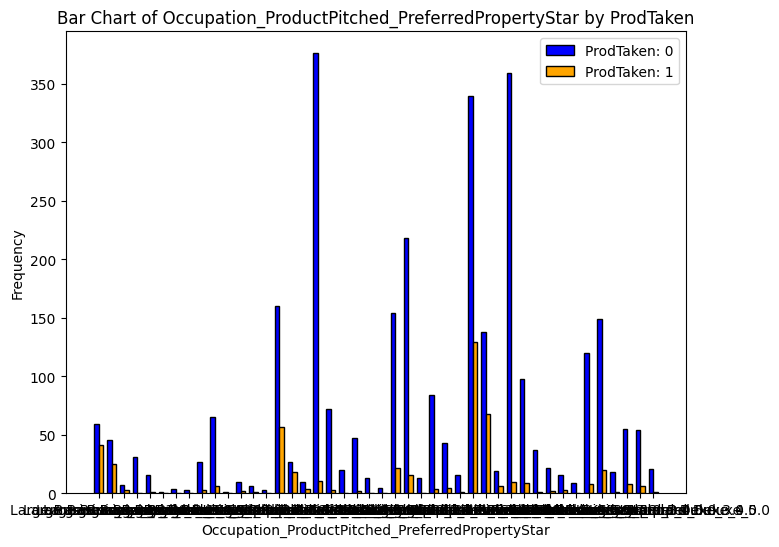

ProdTaken,0,1,ProdTaken_1_ratio
Occupation_ProductPitched_PreferredPropertyStar,,,
Large Business_Basic_3.0,59,41,0.410000
Large Business_Basic_4.0,46,25,0.352113
Large Business_Basic_5.0,7,3,0.300000
Large Business_Deluxe_3.0,31,0,0.000000
Large Business_Deluxe_4.0,16,1,0.058824
Large Business_Deluxe_5.0,1,0,0.000000
Large Business_King_3.0,4,0,0.000000
Large Business_King_4.0,3,0,0.000000
Large Business_Standard_3.0,27,3,0.100000


In [155]:
category_and_category('Occupation_ProductPitched', 'PreferredPropertyStar')
barplots(train_df, 'Occupation_ProductPitched_PreferredPropertyStar')
crosstab_df('Occupation_ProductPitched_PreferredPropertyStar')

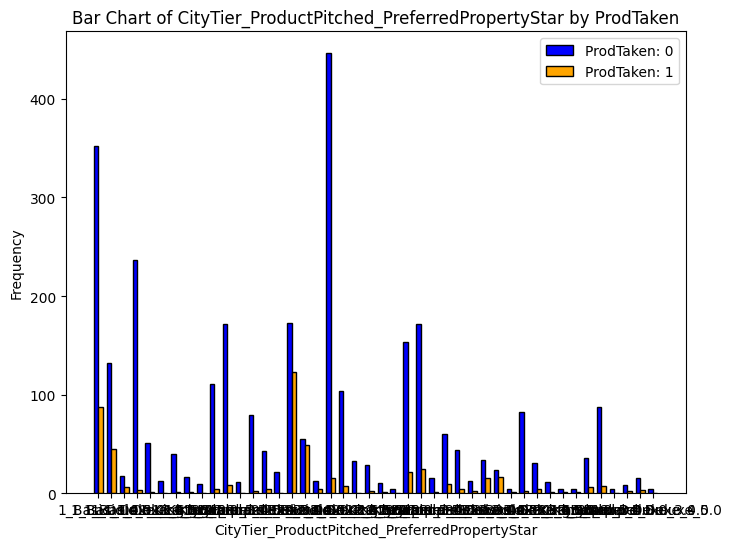

ProdTaken,0,1,ProdTaken_1_ratio
CityTier_ProductPitched_PreferredPropertyStar,,,
1_Basic_3.0,352,88,0.200000
1_Basic_4.0,132,45,0.254237
1_Basic_5.0,18,7,0.280000
1_Deluxe_3.0,237,3,0.012500
1_Deluxe_4.0,51,1,0.019231
1_Deluxe_5.0,13,0,0.000000
1_King_3.0,40,1,0.024390
1_King_4.0,17,1,0.055556
1_King_5.0,10,0,0.000000


In [156]:
category_and_category('CityTier_ProductPitched', 'PreferredPropertyStar')
barplots(train_df, 'CityTier_ProductPitched_PreferredPropertyStar')
crosstab_df('CityTier_ProductPitched_PreferredPropertyStar')

# NumberOfTrips

In [157]:
train_df['NumberOfTrips'].value_counts()

,count
NumberOfTrips,
2,1006
3,699
5,436
1,349
7,219
年に2回,141
4,141
年に3回,121
6,109


In [158]:
test_df['NumberOfTrips'].value_counts()

,count
NumberOfTrips,
2,950
3,762
5,400
1,320
7,226
年に2回,153
4,136
6,125
年に3回,124


In [159]:
train_df['NumberOfTrips'] = train_df['NumberOfTrips'].replace({
    '年に1回': 1, '年に2回': 2, '年に3回': 3, '年に4回': 4,
    '年に5回': 5, '年に6回': 6, '年に7回': 7, '年に8回': 8,
    '半年に1回': 2, '四半期に1回': 4
}, regex=False)

train_df['NumberOfTrips'] = pd.to_numeric(train_df['NumberOfTrips'], errors='coerce')

test_df['NumberOfTrips'] = test_df['NumberOfTrips'].replace({
    '年に1回': 1, '年に2回': 2, '年に3回': 3, '年に4回': 4,
    '年に5回': 5, '年に6回': 6, '年に7回': 7, '年に8回': 8,
    '半年に1回': 2, '四半期に1回': 4
}, regex=False)

test_df['NumberOfTrips'] = pd.to_numeric(test_df['NumberOfTrips'], errors='coerce')

In [160]:
train_df['NumberOfTrips'] = train_df['NumberOfTrips'].fillna(train_df['NumberOfTrips'].median())
test_df['NumberOfTrips'] = test_df['NumberOfTrips'].fillna(test_df['NumberOfTrips'].median())

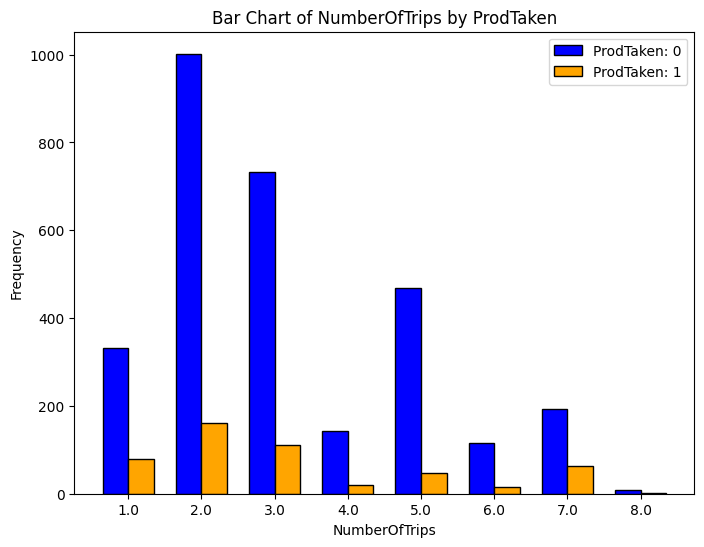

ProdTaken,0,1,ProdTaken_1_ratio
NumberOfTrips,,,
1.0,331,78,0.190709
2.0,1002,162,0.139175
3.0,732,110,0.130641
4.0,142,21,0.128834
5.0,468,47,0.091262
6.0,115,15,0.115385
7.0,194,62,0.242188
8.0,8,2,0.200000


In [161]:
barplots(train_df, 'NumberOfTrips')
crosstab_df('NumberOfTrips')

# Passport

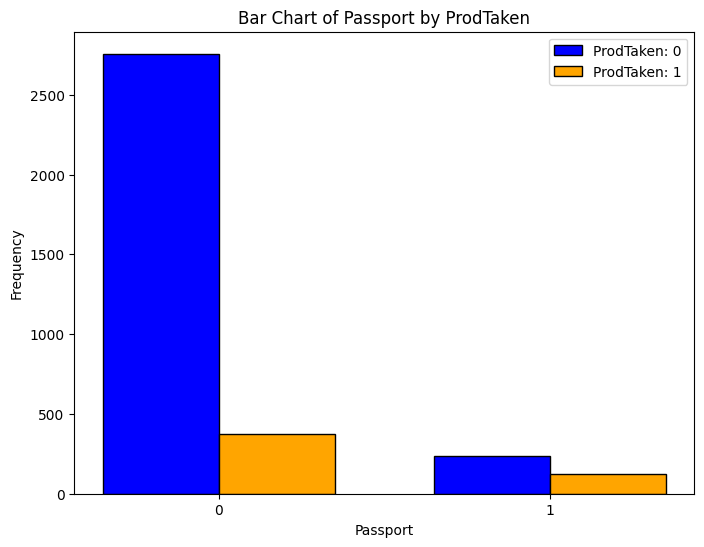

ProdTaken,0,1,ProdTaken_1_ratio
Passport,,,
0,2757,374,0.119451
1,235,123,0.343575


In [162]:
barplots(train_df, 'Passport')
crosstab_df('Passport')

# PitchSatisfactionScore

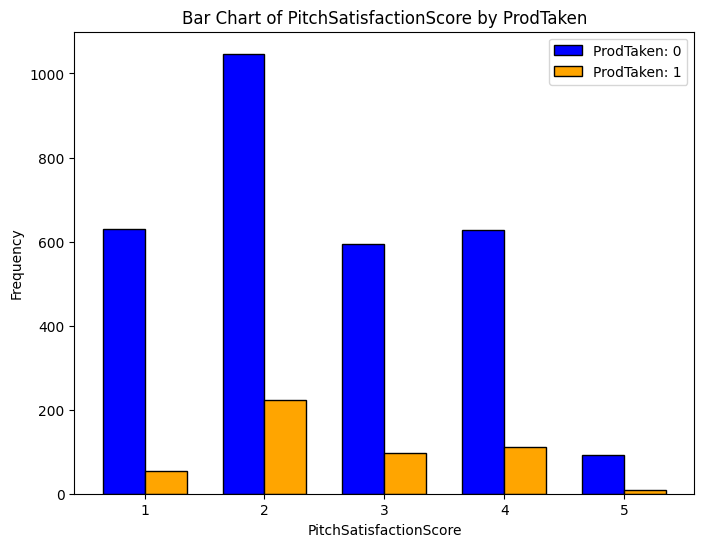

ProdTaken,0,1,ProdTaken_1_ratio
PitchSatisfactionScore,,,
1,631,55,0.080175
2,1047,222,0.174941
3,594,98,0.141618
4,627,112,0.151556
5,93,10,0.097087


In [163]:
barplots(train_df, 'PitchSatisfactionScore')
crosstab_df('PitchSatisfactionScore')

In [164]:
train_df = onehot_encoded(train_df, 'PitchSatisfactionScore')
test_df = onehot_encoded(test_df, 'PitchSatisfactionScore')

# Designation

In [165]:
train_df['Designation'].value_counts()

,count
Designation,
Executive,1090
Manager,1011
Senior Manager,825
AVP,299
VP,117
Μanager,13
Exеcutive,10
Exеcutivе,9
Manαger,8


In [166]:
test_df['Designation'].value_counts()

,count
Designation,
Executive,1129
Manager,1016
Senior Manager,740
AVP,305
VP,142
Exеcutivе,10
Managеr,10
Executivе,9
Exеcutive,9


In [167]:
maneger_words = ['Manager', 'Μanager', 'Manαger', 'Managеr', 'Mαnager', 'Manage𝙧', 'Mαnage𝙧', 'Mαnαger', 'Mαnagеr', 'Μanagеr', 'Manαgеr', 'Μanage𝙧', 'Μαnager', 'Mαnαgеr', 'Μαnagеr', 'Managе𝙧']
seniormanager_words = ['Senior Manager', 'Senior Managеr', 'Senior Manαger', 'Sеnior Manager', 'Senior Mαnαger', 'Senior Manage𝙧', 'Տenior Manager', 'Ѕenior Manager', 'Sеnior Managеr', 'Senior Mαnager', 'Ѕenior Manαger', 'Տenior Μanager', 'Senior Μanαger', 'Senior Managе𝙧', 'Senio𝙧 Manager', 'Senior Μanager', 'Senio𝙧 Mαnage𝙧', 'Sеnior Managе𝙧', 'Senio𝙧 Managеr', 'Ѕenior Μanage𝙧', 'Senio𝙧 Manαger', 'Senio𝙧 Manage𝙧', 'Sеnio𝙧 Manager']
executive_words = ['Executive', 'Exеcutive', 'Exеcutivе', 'Executivе', 'Executiѵe', 'Execuｔive', 'Exеcutiѵе', 'Еxecutive', 'Exеcｕtive', 'Е×еcutive', 'E×ecutive', 'Executiѵе', 'Еxecutivе', 'E×ecｕtive', 'Еxecuｔive', 'E×еcutiѵe', 'Execｕtive', 'Exеcｕtivе', 'Еxеcutivе', 'Е×ecutive', 'Exеcuｔive', 'Execｕｔive', 'Execｕtivе', 'Еxecｕtive']
avp_words = ['AVP', 'АVP', 'ΑVP', 'AVＰ', 'ΑVＰ', 'АVＰ']
vp_words= ['VP', 'VＰ']

train_df['Designation'] = train_df['Designation'].apply(lambda x: 'Manager' if x in maneger_words else ('Senior Manager' if x in seniormanager_words else ('Executive' if x in executive_words else ('AVP' if x in avp_words else ('VP' if x in vp_words else x)))))
test_df['Designation'] = test_df['Designation'].apply(lambda x: 'Manager' if x in maneger_words else ('Senior Manager' if x in seniormanager_words else ('Executive' if x in executive_words else ('AVP' if x in avp_words else ('VP' if x in vp_words else x)))))

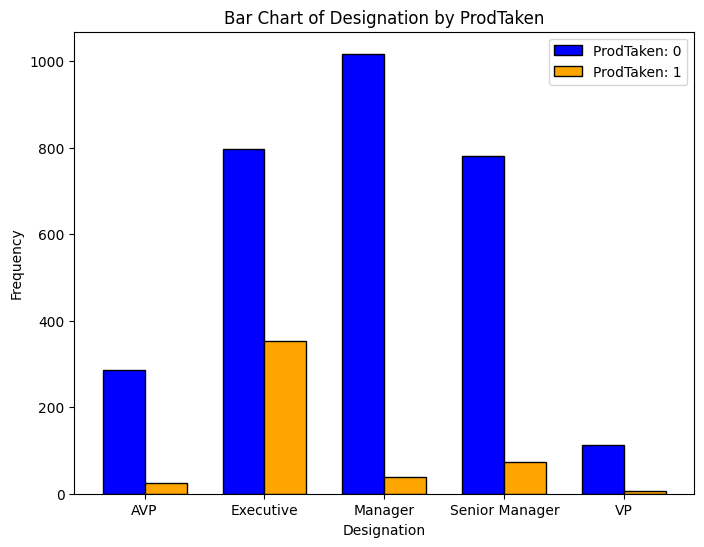

ProdTaken,0,1,ProdTaken_1_ratio
Designation,,,
AVP,287,24,0.077170
Executive,796,354,0.307826
Manager,1017,38,0.036019
Senior Manager,780,74,0.086651
VP,112,7,0.058824


In [168]:
barplots(train_df, 'Designation')
crosstab_df('Designation')

In [169]:
train_df = onehot_encoded(train_df, 'Designation')
test_df = onehot_encoded(test_df, 'Designation')

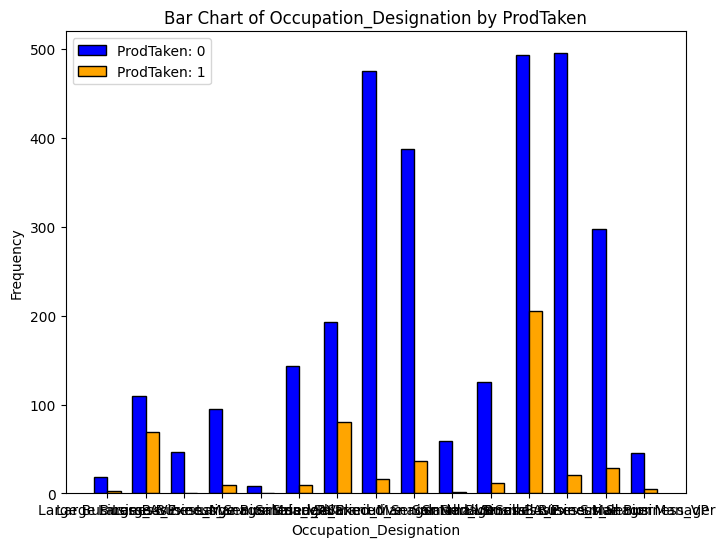

ProdTaken,0,1,ProdTaken_1_ratio
Occupation_Designation,,,
Large Business_AVP,19,3,0.136364
Large Business_Executive,110,69,0.385475
Large Business_Manager,47,1,0.020833
Large Business_Senior Manager,95,9,0.086538
Large Business_VP,8,0,0.000000
Salaried_AVP,143,9,0.059211
Salaried_Executive,193,80,0.293040
Salaried_Manager,475,16,0.032587
Salaried_Senior Manager,388,36,0.084906


In [170]:
category_and_category('Occupation', 'Designation')
barplots(train_df, 'Occupation_Designation')
crosstab_df('Occupation_Designation')

# MonthlyIncome

In [171]:
train_df['MonthlyIncome'].head(10)

,MonthlyIncome
0,253905.0
1,404475.0
2,278145.0
3,326805.0
4,258435.0
5,月収26.0万円
6,453180.0
7,261900.0
8,247800.0
9,257610.0


In [172]:
def convert_numeric(monthlyincome):
    # 数値型または数値として表現された文字列の場合
    try:
        # 数値型や、数値を表す文字列（例: '300000'）の場合はそのまま数値型に変換
        return float(monthlyincome)
    except (ValueError, TypeError):
        pass  # 数値として変換できない場合は次の処理へ

    # 文字列型で特殊なフォーマットの場合
    if isinstance(monthlyincome, str):
        if '月収' in monthlyincome:
            monthlyincome = monthlyincome.replace('月収', '').replace('万円', '').strip()
            return int(float(monthlyincome) * 10000)
        elif '万円' in monthlyincome:
            monthlyincome = monthlyincome.replace('万円', '').strip()
            return int(float(monthlyincome) * 10000)

    # その他の場合は NaN を返す
    return np.nan

train_df['MonthlyIncome'] = train_df['MonthlyIncome'].apply(convert_numeric)
test_df['MonthlyIncome'] = test_df['MonthlyIncome'].apply(convert_numeric)

train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median())
test_df['MonthlyIncome'] = test_df['MonthlyIncome'].fillna(test_df['MonthlyIncome'].median())


In [173]:
train_df['MonthlyIncome'].head(10)

,MonthlyIncome
0,253905.0
1,404475.0
2,278145.0
3,326805.0
4,258435.0
5,260000.0
6,453180.0
7,261900.0
8,247800.0
9,257610.0


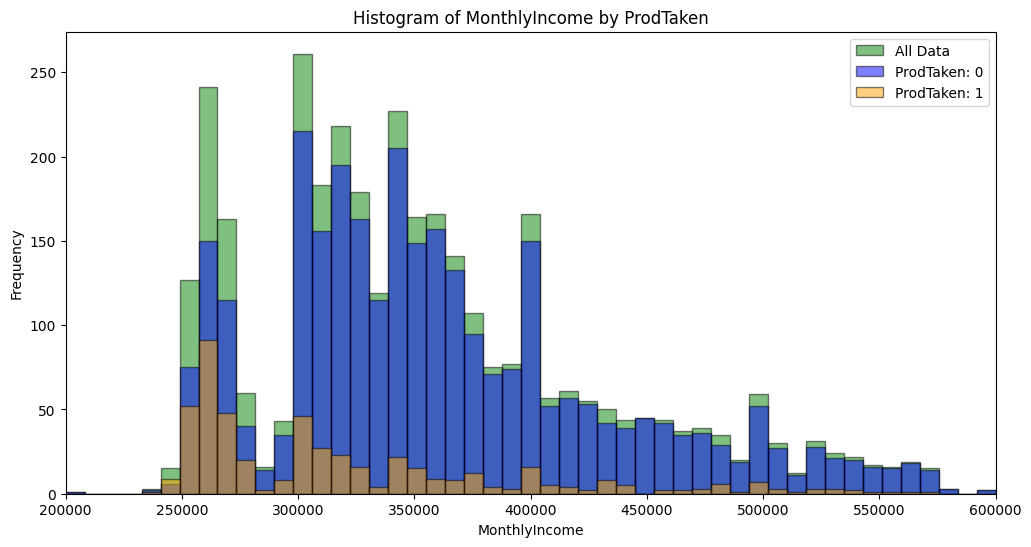

In [174]:
plot_histograms(train_df, 'MonthlyIncome', bins=50)

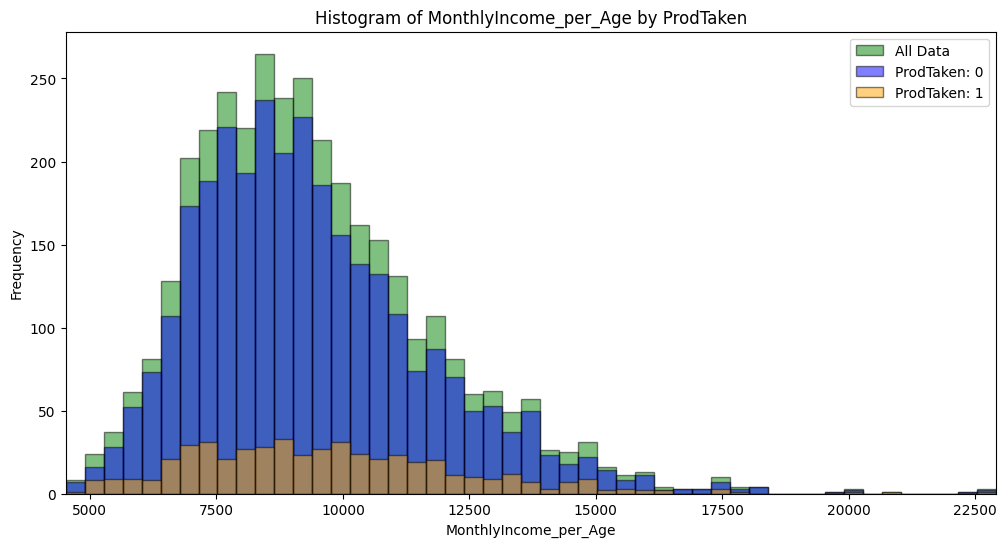

In [175]:
train_df['MonthlyIncome_per_Age'] = train_df['MonthlyIncome'] / train_df['Age']
test_df['MonthlyIncome_per_Age'] = test_df['MonthlyIncome'] / test_df['Age']

plot_histograms(train_df, 'MonthlyIncome_per_Age', bins=50)

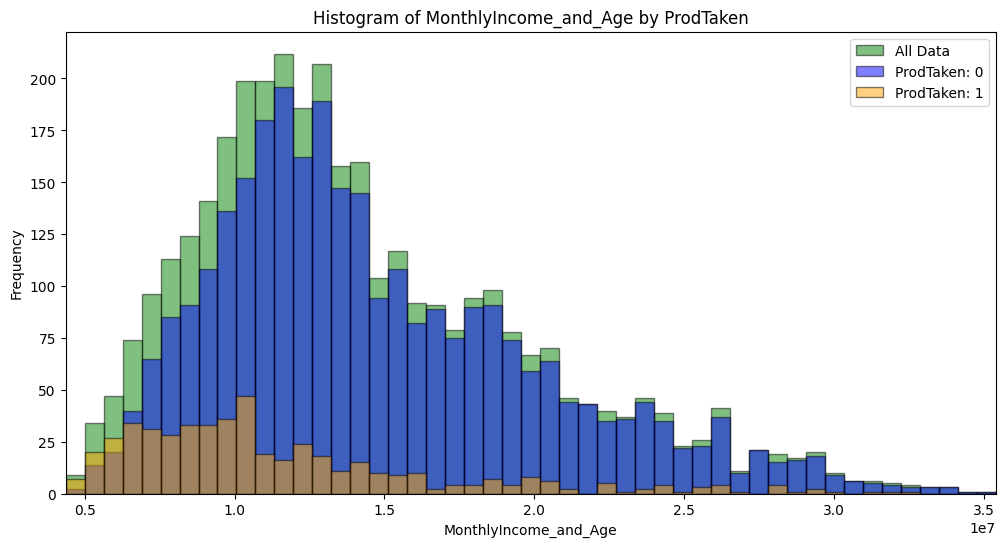

In [176]:
train_df['MonthlyIncome_and_Age'] = train_df['MonthlyIncome'] * train_df['Age']
test_df['MonthlyIncome_and_Age'] = test_df['MonthlyIncome'] * test_df['Age']

plot_histograms(train_df, 'MonthlyIncome_and_Age', bins=50)

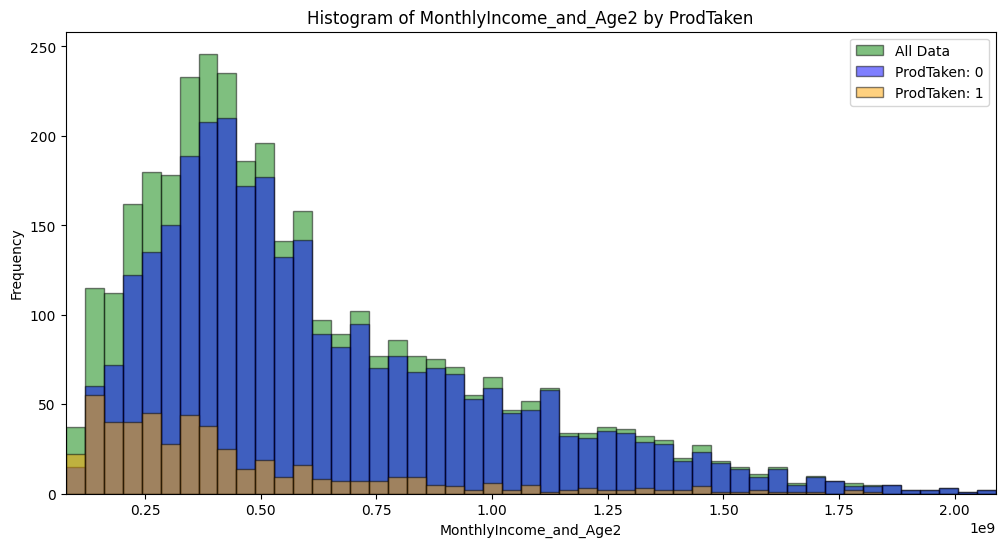

In [177]:
train_df['MonthlyIncome_and_Age2'] = train_df['MonthlyIncome'] * train_df['Age'] * train_df['Age']
test_df['MonthlyIncome_and_Age2'] = test_df['MonthlyIncome'] * test_df['Age'] * test_df['Age']

plot_histograms(train_df, 'MonthlyIncome_and_Age2', bins=50)

# customer_info

In [178]:
train_df['customer_info'].value_counts().head(20)

,count
customer_info,
結婚済み、車未所持、子供1人,34
結婚済み、車所持、子供1人,31
結婚済み、自動車未所有、子供1人,20
離婚済み、車未所持、子供1人,20
離婚済み、車所持、子供1人,19
離婚済み、車所持、子供なし,18
未婚、車未所持、子供1人,18
離婚済み、車未所持、子供なし,17
離婚済み 車所持 子供1人,16


In [179]:
# 'customer_info' カラムを分解
# 分割処理
def split_info(info):
    # 最初の2つの要素と、それ以降を分割
    parts = info.split(' ', 2)  # 2 つ目の要素まで分割し、それ以降をまとめる
    if len(parts) == 3:
        return parts[0], parts[1], parts[2]
    elif len(parts) == 2:
        return parts[0], parts[1], ''  # 3つ目が存在しない場合、空文字列を返す
    elif len(parts) == 1:
        return parts[0], '', ''  # 2つ目と3つ目が存在しない場合
    return '', '', ''  # 万が一何もない場合

train_df['customer_info'] = (
    train_df['customer_info']
    .str.replace('、', ' ', regex=False)
    .str.replace(',', ' ', regex=False)
    .str.replace('/', ' ', regex=False)
    .str.replace('／', ' ', regex=False)
    .str.replace('\n', ' ', regex=False)
    .str.replace('\t', ' ', regex=False)
    .str.replace('　', ' ', regex=False)
)
train_df[['MaritalStatus', 'CarOwnership', 'Children']] = train_df['customer_info'].apply(lambda x: pd.Series(split_info(x)))

test_df['customer_info'] = (
    test_df['customer_info']
    .str.replace('、', ' ', regex=False)
    .str.replace(',', ' ', regex=False)
    .str.replace('/', ' ', regex=False)
    .str.replace('／', ' ', regex=False)
    .str.replace('\n', ' ', regex=False)
    .str.replace('\t', ' ', regex=False)
    .str.replace('　', ' ', regex=False)
)
test_df[['MaritalStatus', 'CarOwnership', 'Children']] = test_df['customer_info'].apply(lambda x: pd.Series(split_info(x)))

# 結果を確認
train_df[['customer_info', 'MaritalStatus', 'CarOwnership', 'Children']].head()

,customer_info,MaritalStatus,CarOwnership,Children
0,未婚 車未所持 子供なし,未婚,車未所持,子供なし
1,離婚済み 車あり 子供無し,離婚済み,車あり,子供無し
2,結婚済み 自動車未所有 子供なし,結婚済み,自動車未所有,子供なし
3,離婚済み 車所持 子供無し,離婚済み,車所持,子供無し
4,独身 車所持 無子,独身,車所持,無子


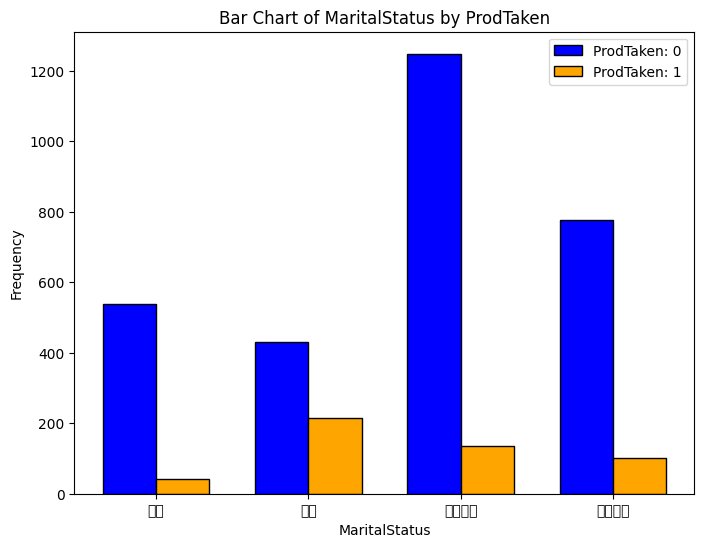

ProdTaken,0,1,ProdTaken_1_ratio
MaritalStatus,,,
未婚,538,43,0.074010
独身,430,216,0.334365
結婚済み,1248,136,0.098266
離婚済み,776,102,0.116173


In [180]:
barplots(train_df, 'MaritalStatus')
crosstab_df('MaritalStatus')

In [181]:
train_df = onehot_encoded(train_df, 'MaritalStatus')
test_df = onehot_encoded(test_df, 'MaritalStatus')

In [182]:
train_df['Family_num1'] = train_df['MaritalStatus'].apply(lambda x: 2 if x == '結婚済み' else 1)
test_df['Family_num1'] = test_df['MaritalStatus'].apply(lambda x : 2 if x == '結婚済み' else 1)

In [183]:
car_words = ['車所持', '自動車所有', '自家用車あり', '乗用車所持', '車保有', '車あり']
noncar_words = ['車未所持', '自動車未所有', '自家用車なし', '乗用車なし', '車保有なし', '車なし']

train_df['CarOwnership'] = train_df['CarOwnership'].apply(lambda x: 'Car' if x in car_words else ('Non-Car' if x in noncar_words else x))
test_df['CarOwnership'] = test_df['CarOwnership'].apply(lambda x: 'Car' if x in car_words else ('Non-Car' if x in noncar_words else x))

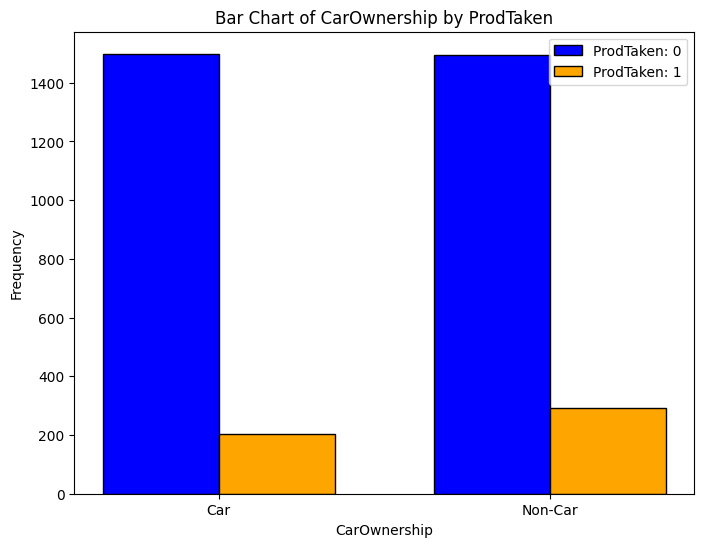

ProdTaken,0,1,ProdTaken_1_ratio
CarOwnership,,,
Car,1499,205,0.120305
Non-Car,1493,292,0.163585


In [184]:
barplots(train_df, 'CarOwnership')
crosstab_df('CarOwnership')

In [185]:
train_df['Children'].value_counts()

,count
Children,
子供1人,859
子供なし,539
子供2人,434
こども1人,410
子供無し,252
こども2人,229
1児,113
子供有り(1人),94
子供有り 1人,94


In [186]:
train_df['Children'].value_counts().sum()

3489

In [187]:
test_df['Children'].value_counts()

,count
Children,
子供1人,840
子供なし,499
子供2人,487
こども1人,422
子供無し,255
こども2人,227
1児,107
子供有り(1人),100
子供有り 1人,95


In [188]:
test_df['Children'].value_counts().sum()

3489

In [189]:
onechild_words = ['子供1人', 'こども1人', '1児', '子供有り(1人)', '子供有り 1人']
twochildren_words = ['子供2人', 'こども2人', '子供有り 2人', '2児', '子供有り(2人)']
threechildren_words = ['子供3人', 'こども3人', '3児', '子供有り 3人', '子供有り(3人)']
unknown_words = ['子供の数不明', '不明', 'わからない', '子育て状況不明', '子の数不詳']
nonchild_words = ['子供なし', '子供無し', '子供ゼロ', '非育児家庭', '無子']

train_df['Children'] = train_df['Children'].apply(lambda x: 1 if x in onechild_words else (2 if x in twochildren_words else (3 if x in threechildren_words else (np.nan if x in unknown_words else (0 if x in nonchild_words else x)))))
test_df['Children'] = test_df['Children'].apply(lambda x: 1 if x in onechild_words else (2 if x in twochildren_words else (3 if x in threechildren_words else (np.nan if x in unknown_words else (0 if x in nonchild_words else x)))))

In [190]:
def has_children_col(train_df, test_df):
    train_df['has_children'] = train_df['Children'].apply(lambda x: 1 if x > 0 else 0)
    test_df['has_children'] = test_df['Children'].apply(lambda x: 1 if x > 0 else 0)

has_children_col(train_df, test_df)

In [191]:
def fill_children(row):
    if pd.isna(row['Children']):  # Children が欠損値の場合
        if row['MaritalStatus'] in ['未婚', '独身', '離婚済み']:
            return 0
        else:
            return 1
    return row['Children']  # 欠損値でない場合はそのまま返す

# 各行に適用
train_df['Children'] = train_df.apply(fill_children, axis=1)
test_df['Children'] = test_df.apply(fill_children, axis=1)

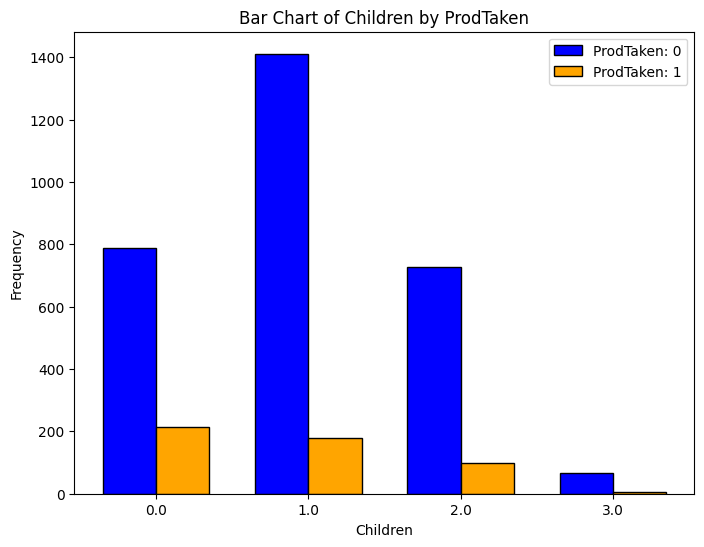

ProdTaken,0,1,ProdTaken_1_ratio
Children,,,
0.0,787,214,0.213786
1.0,1411,180,0.113136
2.0,726,98,0.118932
3.0,68,5,0.068493


In [192]:
barplots(train_df, 'Children')
crosstab_df('Children')

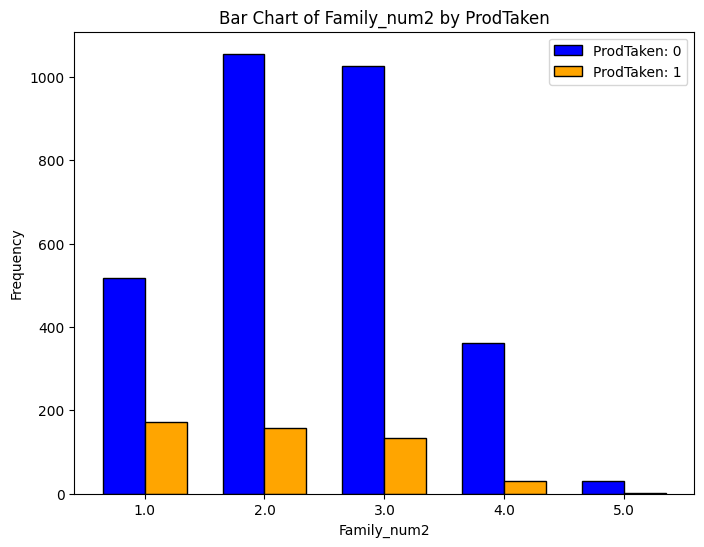

ProdTaken,0,1,ProdTaken_1_ratio
Family_num2,,,
1.0,518,172,0.249275
2.0,1056,158,0.130148
3.0,1026,134,0.115517
4.0,361,31,0.079082
5.0,31,2,0.060606


In [193]:
train_df['Family_num2'] = train_df['Family_num1'] + train_df['Children']
test_df['Family_num2'] = test_df['Family_num1'] + test_df['Children']

barplots(train_df, 'Family_num2')
crosstab_df('Family_num2')

# 欠損値予測

In [194]:
# train_df['Age'] = train_df['Age'].astype(float)
# test_df['Age'] = test_df['Age'].astype(float)

In [195]:
# for col in train_df.columns:
#   if train_df[col].dtypes == 'object':
#     train_df[col] = train_df[col].astype('category')

# for col in test_df.columns:
#   if test_df[col].dtypes == 'object':
#     test_df[col] = test_df[col].astype('category')

In [196]:
# features_for_age = [
#     'TypeofContact', 'CityTier', 'Occupation', 'Gender',
#     'NumberOfPersonVisiting', 'ProductPitched',
#     'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore',
#     'Designation',  'MaritalStatus', 'CarOwnership', 'Family_num2',
# ]
# x_train_age = train_df[features_for_age]
# y_train_age = train_df['Age']
# x_test_age = test_df[features_for_age]
# y_test_age = train_df['Age']

# params = {
#     "objective": "regression",  # 回帰タスク
#     "random_state": 123,       # 再現性のための乱数シード
#     "n_estimators": 100,       # 決定木の数（デフォルト100）
#     "learning_rate": 0.1       # 学習率（デフォルト0.1）
# }


# model = lgb.LGBMRegressor(**params)  # 年齢は連続値なので回帰モデルを使用
# model.fit(
#     x_train_age, y_train_age,
#     eval_set=[(x_train_age, y_train_age)],
#     callbacks=[
#         lgb.callback.early_stopping(stopping_rounds=50),
#         lgb.callback.log_evaluation(period=10)
#     ]
# )

# # 欠損値を予測
# predicted_train_ages = np.round(model.predict(x_train_age))  # train の欠損値
# predicted_test_ages = np.round(model.predict(x_test_age))    # test の欠損値



# # 欠損値を埋める
# train_df.loc[train_df['Age'].isna(), 'Age'] = predicted_train_ages[train_df['Age'].isna()]
# test_df.loc[test_df['Age'].isna(), 'Age'] = predicted_test_ages[test_df['Age'].isna()]
# print(train_df['Age'].isna().sum())

In [197]:
# plot_histograms(train_df, 'Age', bins=48)

In [198]:
# bins = [10, 20, 25, 30, 35, 40, 60, 70]
# labels = ['10-19', '20-24', '25-29', '30-34', '35-39', '40-59', '60-69']

# train_df['Age_group'] = pd.cut(train_df['Age'], bins=bins, labels=labels, right=False)
# test_df['Age_group'] = pd.cut(test_df['Age'], bins=bins, labels=labels, right=False)

# crosstab_df('Age_group')

In [199]:
# # 欠損値を埋めたので、もう一度作成
# train_df['MonthlyIncome_and_Age'] = train_df['MonthlyIncome'] * train_df['Age']
# test_df['MonthlyIncome_and_Age'] = test_df['MonthlyIncome'] * test_df['Age']

In [200]:
# train_df['DurationOfPitch_min'] = train_df['DurationOfPitch_min'].astype(float)
# test_df['DurationOfPitch_min'] = test_df['DurationOfPitch_min'].astype(float)

# features_for_duration = [
#     'TypeofContact', 'CityTier', 'Occupation', 'Gender',
#     'NumberOfPersonVisiting', 'ProductPitched',
#     'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore',
#     'Designation',  'MaritalStatus', 'CarOwnership', 'Family_num2',
# ]
# x_train_age = train_df[features_for_age]
# y_train_age = train_df['DurationOfPitch_min']
# x_test_age = test_df[features_for_age]
# y_test_age = train_df['DurationOfPitch_min']

# params = {
#     "objective": "regression",  # 回帰タスク
#     "random_state": 123,       # 再現性のための乱数シード
#     "n_estimators": 100,       # 決定木の数（デフォルト100）
#     "learning_rate": 0.1       # 学習率（デフォルト0.1）
# }


# model = lgb.LGBMRegressor(**params)  # 年齢は連続値なので回帰モデルを使用
# model.fit(
#     x_train_age, y_train_age,
#     eval_set=[(x_train_age, y_train_age)],
#     callbacks=[
#         lgb.callback.early_stopping(stopping_rounds=50),
#         lgb.callback.log_evaluation(period=10)
#     ]
# )

# # 欠損値を予測
# predicted_train_ages = np.round(model.predict(x_train_age))  # train の欠損値
# predicted_test_ages = np.round(model.predict(x_test_age))    # test の欠損値



# # 欠損値を埋める
# train_df.loc[train_df['DurationOfPitch_min'].isna(), 'DurationOfPitch_min'] = predicted_train_ages[train_df['DurationOfPitch_min'].isna()]
# test_df.loc[test_df['DurationOfPitch_min'].isna(), 'DurationOfPitch_min'] = predicted_test_ages[test_df['DurationOfPitch_min'].isna()]
# print(train_df['DurationOfPitch_min'].isna().sum())

In [201]:
# plot_histograms(train_df, 'DurationOfPitch_min', bins=33)

In [202]:
# bins = [0, 6, 16, 21, 31, 40]
# labels = ['0-5', '6-15', '16-20', '21-30', '31-40']

# train_df['DurationOfPitch_group'] = pd.cut(train_df['DurationOfPitch_min'], bins=bins, labels=labels, right=False)
# test_df['DurationOfPitch_group'] = pd.cut(test_df['DurationOfPitch_min'], bins=bins, labels=labels, right=False)

# crosstab_df('DurationOfPitch_group')

In [203]:
# train_df['MonthlyIncome'] = train_df['MonthlyIncome'].astype(float)
# test_df['MonthlyIncome'] = test_df['MonthlyIncome'].astype(float)

# features_for_income = [
#     'TypeofContact', 'CityTier', 'Occupation', 'Gender',
#     'NumberOfPersonVisiting', 'ProductPitched',
#     'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore',
#     'Designation',  'MaritalStatus', 'CarOwnership', 'Family_num2',
# ]
# x_train_age = train_df[features_for_age]
# y_train_age = train_df['MonthlyIncome']
# x_test_age = test_df[features_for_age]
# y_test_age = train_df['MonthlyIncome']

# params = {
#     "objective": "regression",  # 回帰タスク
#     "random_state": 123,       # 再現性のための乱数シード
#     "n_estimators": 100,       # 決定木の数（デフォルト100）
#     "learning_rate": 0.1       # 学習率（デフォルト0.1）
# }


# model = lgb.LGBMRegressor(**params)  # 年齢は連続値なので回帰モデルを使用
# model.fit(
#     x_train_age, y_train_age,
#     eval_set=[(x_train_age, y_train_age)],
#     callbacks=[
#         lgb.callback.early_stopping(stopping_rounds=50),
#         lgb.callback.log_evaluation(period=10)
#     ]
# )

# # 欠損値を予測
# predicted_train_ages = np.round(model.predict(x_train_age))  # train の欠損値
# predicted_test_ages = np.round(model.predict(x_test_age))    # test の欠損値



# # 欠損値を埋める
# train_df.loc[train_df['MonthlyIncome'].isna(), 'MonthlyIncome'] = predicted_train_ages[train_df['MonthlyIncome'].isna()]
# test_df.loc[test_df['MonthlyIncome'].isna(), 'MonthlyIncome'] = predicted_test_ages[test_df['MonthlyIncome'].isna()]
# print(train_df['MonthlyIncome'].isna().sum())

In [204]:
# # 欠損値を埋めたので、もう一度作成
# train_df['MonthlyIncome_and_Age'] = train_df['MonthlyIncome'] * train_df['Age']
# test_df['MonthlyIncome_and_Age'] = test_df['MonthlyIncome'] * test_df['Age']

# データセット

In [205]:
for col in train_df.columns:
  if train_df[col].dtypes == 'object':
    train_df[col] = train_df[col].astype('category')

for col in test_df.columns:
  if test_df[col].dtypes == 'object':
    test_df[col] = test_df[col].astype('category')

In [206]:
# def trans_category(features_trans_cat):
#   for col in features_trans_cat:
#     train_df[col] = train_df[col].astype('category')
#     test_df[col] = test_df[col].astype('category')

# features_trans_cat = [
#     'Passport'
#                       ]

# trans_category(features_trans_cat)

In [207]:
information_df(train_df)

(index, col) : (3489, 65)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,3489,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
Age,Int64,0,44,"[50, 56, 38, 37, 48, 19, 47, 49, 33, 31, 51, 4..."
TypeofContact,int64,0,2,"[1, 0]"
CityTier,int64,0,3,"[2, 1, 3]"
DurationOfPitch,category,121,65,"[900秒, 14分, 10分, 1080秒, 1020秒, 16分, 840秒, 22分,..."
Occupation,category,0,3,"[Large Business, Salaried, Small Business]"
Gender,int64,0,2,"[0, 1]"
NumberOfPersonVisiting,float64,0,4,"[1.0, 2.0, 3.0, 4.0]"
NumberOfFollowups,float64,0,6,"[4.0, 3.0, 5.0, 1.0, 2.0, 6.0]"
ProductPitched,category,0,5,"[Basic, Standard, Super Deluxe, Deluxe, King]"


In [208]:
information_df(test_df)

(index, col) : (3489, 64)


,dtypes,NaN Count,Nunique,Unique Values
id,int64,0,3489,"[3489, 3490, 3491, 3492, 3493, 3494, 3495, 349..."
Age,Int64,0,44,"[48, 36, 25, 21, 41, 45, 44, 30, 31, 47, 43, 5..."
TypeofContact,int64,0,2,"[1, 0]"
CityTier,int64,0,3,"[2, 1, 3]"
DurationOfPitch,category,131,65,"[13分, 12分, 540秒, 420秒, 7分, nan, 8分, 16分, 22分, ..."
Occupation,category,0,3,"[Small Business, Salaried, Large Business]"
Gender,int64,0,2,"[0, 1]"
NumberOfPersonVisiting,float64,0,4,"[1.0, 2.0, 3.0, 4.0]"
NumberOfFollowups,float64,0,6,"[4.0, 3.0, 5.0, 1.0, 2.0, 6.0]"
ProductPitched,category,0,5,"[Super Deluxe, Standard, Basic, Deluxe, King]"


In [209]:
train_df.columns.tolist()

['id',
 'Age',
 'TypeofContact',
 'CityTier',
 'DurationOfPitch',
 'Occupation',
 'Gender',
 'NumberOfPersonVisiting',
 'NumberOfFollowups',
 'ProductPitched',
 'PreferredPropertyStar',
 'NumberOfTrips',
 'Passport',
 'PitchSatisfactionScore',
 'Designation',
 'MonthlyIncome',
 'customer_info',
 'ProdTaken',
 'CityTier_1',
 'CityTier_2',
 'CityTier_3',
 'DurationOfPitch_sec',
 'DurationOfPitch_min',
 'DurationOfPitch_group',
 'Occupation_Large Business',
 'Occupation_Salaried',
 'Occupation_Small Business',
 'TypeofContact_Occupation',
 'Duration_per_Followups',
 'ProductPitched_Basic',
 'ProductPitched_Deluxe',
 'ProductPitched_King',
 'ProductPitched_Standard',
 'ProductPitched_Super Deluxe',
 'Occupation_ProductPitched',
 'CityTier_ProductPitched',
 'PreferredPropertyStar_3.0',
 'PreferredPropertyStar_4.0',
 'PreferredPropertyStar_5.0',
 'Occupation_ProductPitched_PreferredPropertyStar',
 'CityTier_ProductPitched_PreferredPropertyStar',
 'PitchSatisfactionScore_1',
 'PitchSatisfacti

In [210]:
features = [
 'TypeofContact',
#  'CityTier',
 'DurationOfPitch',
#  'Occupation',
 'Gender',
 'NumberOfPersonVisiting',
 'NumberOfFollowups',
#  'ProductPitched',
#  'PreferredPropertyStar',
 'NumberOfTrips',
 'Passport',
#  'PitchSatisfactionScore',
#  'Designation',
 'MonthlyIncome',
#  'customer_info',
#  'ProdTaken',
 'CityTier_1',
 'CityTier_2',
#  'CityTier_3',
#  'DurationOfPitch_sec',
 'DurationOfPitch_min',
#  'DurationOfPitch_group',
 'Occupation_Large Business',
 'Occupation_Salaried',
#  'Occupation_Small Business',
#  'TypeofContact_Occupation',
#  'Duration_per_Followups',
 'ProductPitched_Basic',
 'ProductPitched_Deluxe',
 'ProductPitched_King',
 'ProductPitched_Standard',
#  'ProductPitched_Super Deluxe',
#  'Occupation_ProductPitched',
#  'CityTier_ProductPitched',
 'PreferredPropertyStar_3.0',
 'PreferredPropertyStar_4.0',
#  'PreferredPropertyStar_5.0',
#  'Occupation_ProductPitched_PreferredPropertyStar',
#  'CityTier_ProductPitched_PreferredPropertyStar',
 'PitchSatisfactionScore_1',
 'PitchSatisfactionScore_2',
 'PitchSatisfactionScore_3',
 'PitchSatisfactionScore_4',
#  'PitchSatisfactionScore_5',
 'Designation_AVP',
 'Designation_Executive',
 'Designation_Manager',
 'Designation_Senior Manager',
#  'Designation_VP',
#  'Occupation_Designation',
#  'MonthlyIncome_per_Age',
#  'MonthlyIncome_and_Age',
#  'MonthlyIncome_and_Age2',
#  'MaritalStatus',
 'CarOwnership',
 'Children',
 'MaritalStatus_未婚',
 'MaritalStatus_独身',
 'MaritalStatus_結婚済み',
#  'MaritalStatus_離婚済み',
#  'Family_num1',
 'has_children',
#  'Family_num2'
]

# features_category = [
#   'Occupation', 'Gender', 'ProductPitched', 'Designation', 'MaritalStatus', 'CityTier_ProductPitched',
#   'Passport', 'Age_group', 'DurationOfPitch_group'
# ]

x_train = train_df[features]
y_train = train_df['ProdTaken']
x_test = test_df[features]

In [225]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'random_state': 777,
    'num_leaves': 20,
    'n_estimators': 3000,
    'importance_type': 'gain',
    'verbose': -1,
    'lambda_l1': 0.8,
    'lambda_l2': 90,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'subsumple': 0.8,
    'subsample_freq': 1,
}


# params_cat = {
#     'iterations': 2000,
#     'learning_rate': 0.05,
#     'depth': 4,
#     'loss_function': 'Logloss',
#     'verbose': -1,
#     'eval_metric': 'AUC',
#     'random_seed': 123,
#     'l2_leaf_reg': 0.5,
#     'bootstrap_type': 'Bernoulli',
#     'subsample': 0.6,
#     'colsample_bylevel': 0.6,
#     'one_hot_max_size': 10,
#     'min_data_in_leaf': 150,
# }

In [226]:
models1 = []
metric=[]
imp=pd.DataFrame()
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

for nfold, (train_index, val_index) in enumerate(cv.split(x_train, y_train)):
    print('-'*20, nfold, '-'*20)
    x_tr, y_tr = x_train.iloc[train_index], y_train.iloc[train_index]
    x_va, y_va = x_train.iloc[val_index], y_train.iloc[val_index]

    # model = CatBoostClassifier(**params_cat)
    # train_pool = Pool(x_tr, y_tr, cat_features=features_category)
    # val_pool = Pool(x_va, y_va, cat_features=features_category)
    # model.fit(
    #     train_pool,
    #     eval_set=val_pool,
    #     early_stopping_rounds=100,
    #     verbose=100
    # )

    model = lgb.LGBMClassifier(**params)
    model.fit(
        x_tr, y_tr,
        eval_set= [(x_tr, y_tr), (x_va, y_va)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100)
        ]
    )

    y_tr_pred = model.predict_proba(x_tr)[:, 1]
    y_va_pred = model.predict_proba(x_va)[:, 1]

    metric_tr = roc_auc_score(y_tr, y_tr_pred)
    metric_va = roc_auc_score(y_va, y_va_pred)

    metric.append((nfold, metric_tr, metric_va))
    models1.append(model)

    print("Tr:", metric_tr)
    print("Va:", metric_va)

    _imp = pd.DataFrame({
        'col': x_train.columns,
        'imp': model.feature_importances_,
        'fold': nfold
    })
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

print('-'*50)
print(pd.DataFrame(metric, columns=["Fold", "Train", "Va"]))
print('-'*50)

metric = np.array(metric)
print('[tr]: {:3f}+-{:2f}'.format(metric[:, 1].mean(), metric[:, 1].std()), '[va]: {:3f}+-{:2f}'.format(metric[:, 2].mean(), metric[:, 2].std()))

-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.824898	valid_1's auc: 0.812433
[200]	training's auc: 0.831433	valid_1's auc: 0.820543
[300]	training's auc: 0.83891	valid_1's auc: 0.824666
[400]	training's auc: 0.845878	valid_1's auc: 0.828261
[500]	training's auc: 0.852971	valid_1's auc: 0.832492
[600]	training's auc: 0.858354	valid_1's auc: 0.836204
[700]	training's auc: 0.862456	valid_1's auc: 0.838712
[800]	training's auc: 0.866266	valid_1's auc: 0.839916
[900]	training's auc: 0.86952	valid_1's auc: 0.840769
[1000]	training's auc: 0.872407	valid_1's auc: 0.841338
[1100]	training's auc: 0.874785	valid_1's auc: 0.842324
[1200]	training's auc: 0.877232	valid_1's auc: 0.842726
[1300]	training's auc: 0.879357	valid_1's auc: 0.843361
Early stopping, best iteration is:
[1298]	training's auc: 0.879314	valid_1's auc: 0.843445
Tr: 0.8793141544036414
Va: 0.8434448160535116
-------------------- 1 -----------------

In [213]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

# 初期設定
seed_values = [123, 456, 789, 12, 234, 345, 555, 678, 777, 1024]  # 検証する seed のリスト
n_splits = 5
metric_results = []
imp = pd.DataFrame()

# seed をグリッドサーチ
for seed in seed_values:
    print(f"Testing with seed: {seed}")
    models = []
    metric = []

    params1 = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'random_state': seed,
        'num_leaves': 20,
        'n_estimators': 3000,
        'importance_type': 'gain',
        'verbose': -1,
        'lambda_l1': 0.8,
        'lambda_l2': 90,
        'feature_fraction': 0.4,
        'bagging_fraction': 0.8,
        'bagging_freq': 3,
        'subsumple': 0.8,
        'subsample_freq': 1,
    }

    # Stratified K-Fold クロスバリデーション
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for nfold, (train_index, val_index) in enumerate(cv.split(x_train, y_train)):
        print('-' * 20, f"Seed {seed} - Fold {nfold}", '-' * 20)
        x_tr, y_tr = x_train.iloc[train_index], y_train.iloc[train_index]
        x_va, y_va = x_train.iloc[val_index], y_train.iloc[val_index]

        # LightGBM モデル
        model = lgb.LGBMClassifier(**params1)
        model.fit(
            x_tr, y_tr,
            eval_set=[(x_tr, y_tr), (x_va, y_va)],
            callbacks=[
                lgb.callback.early_stopping(stopping_rounds=100),
                lgb.callback.log_evaluation(period=100)
            ]
        )

        # 予測と評価
        y_tr_pred = model.predict_proba(x_tr)[:, 1]
        y_va_pred = model.predict_proba(x_va)[:, 1]

        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)

        metric.append((nfold, metric_tr, metric_va))
        models.append(model)

        print("Tr:", metric_tr)
        print("Va:", metric_va)

        # 特徴量重要度
        _imp = pd.DataFrame({
            'col': x_train.columns,
            'imp': model.feature_importances_,
            'fold': nfold,
            'seed': seed
        })
        imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

    # 各 seed の結果を記録
    metric = np.array(metric)
    mean_tr = metric[:, 1].mean()
    mean_va = metric[:, 2].mean()
    std_tr = metric[:, 1].std()
    std_va = metric[:, 2].std()
    print(f"[Seed {seed}] Train AUC: {mean_tr:.3f} ± {std_tr:.3f}, Validation AUC: {mean_va:.3f} ± {std_va:.3f}")
    metric_results.append((seed, mean_tr, std_tr, mean_va, std_va))

# グリッドサーチ結果を表示
metric_df = pd.DataFrame(metric_results, columns=['Seed', 'Train Mean AUC', 'Train Std AUC', 'Val Mean AUC', 'Val Std AUC'])
print('-' * 50)
print(metric_df)
print('-' * 50)


Testing with seed: 123
-------------------- Seed 123 - Fold 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.823066	valid_1's auc: 0.838436
[200]	training's auc: 0.828084	valid_1's auc: 0.839022
Early stopping, best iteration is:
[116]	training's auc: 0.823778	valid_1's auc: 0.840192
Tr: 0.8237775378833314
Va: 0.8401923076923078
-------------------- Seed 123 - Fold 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.826718	valid_1's auc: 0.809005
[200]	training's auc: 0.835441	valid_1's auc: 0.81092
[300]	training's auc: 0.842066	valid_1's auc: 0.813161
[400]	training's auc: 0.847635	valid_1's auc: 0.814164
[500]	training's auc: 0.852996	valid_1's auc: 0.817341
[600]	training's auc: 0.857576	valid_1's auc: 0.82214
[700]	training's auc: 0.861336	valid_1's auc: 0.823328
[800]	training's auc: 0.86451	valid_1's auc: 0.825819
[900]	training's auc: 0.867151	valid_1's auc: 0.82

In [227]:
models2 = []
metric=[]
imp=pd.DataFrame()
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=555)

for nfold, (train_index, val_index) in enumerate(cv.split(x_train, y_train)):
    print('-'*20, nfold, '-'*20)
    x_tr, y_tr = x_train.iloc[train_index], y_train.iloc[train_index]
    x_va, y_va = x_train.iloc[val_index], y_train.iloc[val_index]

    params2 = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'random_state': 555,
        'num_leaves': 20,
        'n_estimators': 3000,
        'importance_type': 'gain',
        'verbose': -1,
        'lambda_l1': 0.8,
        'lambda_l2': 90,
        'feature_fraction': 0.4,
        'bagging_fraction': 0.8,
        'bagging_freq': 3,
        'subsumple': 0.8,
        'subsample_freq': 1,
    }

    model = lgb.LGBMClassifier(**params2)
    model.fit(
        x_tr, y_tr,
        eval_set= [(x_tr, y_tr), (x_va, y_va)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100)
        ]
    )

    y_tr_pred = model.predict_proba(x_tr)[:, 1]
    y_va_pred = model.predict_proba(x_va)[:, 1]

    metric_tr = roc_auc_score(y_tr, y_tr_pred)
    metric_va = roc_auc_score(y_va, y_va_pred)

    metric.append((nfold, metric_tr, metric_va))
    models2.append(model)

    print("Tr:", metric_tr)
    print("Va:", metric_va)

    _imp = pd.DataFrame({
        'col': x_train.columns,
        'imp': model.feature_importances_,
        'fold': nfold
    })
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

print('-'*50)
print(pd.DataFrame(metric, columns=["Fold", "Train", "Va"]))
print('-'*50)

metric = np.array(metric)
print('[tr]: {:3f}+-{:2f}'.format(metric[:, 1].mean(), metric[:, 1].std()), '[va]: {:3f}+-{:2f}'.format(metric[:, 2].mean(), metric[:, 2].std()))

-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.826978	valid_1's auc: 0.816756
Early stopping, best iteration is:
[12]	training's auc: 0.819164	valid_1's auc: 0.821706
Tr: 0.8191643045481041
Va: 0.8217056856187291
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.833301	valid_1's auc: 0.800945
[200]	training's auc: 0.840594	valid_1's auc: 0.804381
[300]	training's auc: 0.846066	valid_1's auc: 0.806455
[400]	training's auc: 0.852661	valid_1's auc: 0.809398
[500]	training's auc: 0.858392	valid_1's auc: 0.811689
[600]	training's auc: 0.863502	valid_1's auc: 0.814214
[700]	training's auc: 0.867367	valid_1's auc: 0.814849
[800]	training's auc: 0.870809	valid_1's auc: 0.815753
[900]	training's auc: 0.873443	valid_1's auc: 0.816505
[1000]	training's auc: 0.875805	valid_1's auc: 0.817007
Early stopping, best iteration is:
[949]	traini

In [228]:
models3 = []
metric=[]
imp=pd.DataFrame()
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1024)

for nfold, (train_index, val_index) in enumerate(cv.split(x_train, y_train)):
    print('-'*20, nfold, '-'*20)
    x_tr, y_tr = x_train.iloc[train_index], y_train.iloc[train_index]
    x_va, y_va = x_train.iloc[val_index], y_train.iloc[val_index]

    params1 = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'random_state': 1024,
        'num_leaves': 20,
        'n_estimators': 3000,
        'importance_type': 'gain',
        'verbose': -1,
        'lambda_l1': 0.8,
        'lambda_l2': 90,
        'feature_fraction': 0.4,
        'bagging_fraction': 0.8,
        'bagging_freq': 3,
        'subsumple': 0.8,
        'subsample_freq': 1,
    }

    model = lgb.LGBMClassifier(**params2)
    model.fit(
        x_tr, y_tr,
        eval_set= [(x_tr, y_tr), (x_va, y_va)],
        callbacks=[
            lgb.callback.early_stopping(stopping_rounds=100),
            lgb.callback.log_evaluation(period=100)
        ]
    )

    y_tr_pred = model.predict_proba(x_tr)[:, 1]
    y_va_pred = model.predict_proba(x_va)[:, 1]

    metric_tr = roc_auc_score(y_tr, y_tr_pred)
    metric_va = roc_auc_score(y_va, y_va_pred)

    metric.append((nfold, metric_tr, metric_va))
    models3.append(model)

    print("Tr:", metric_tr)
    print("Va:", metric_va)

    _imp = pd.DataFrame({
        'col': x_train.columns,
        'imp': model.feature_importances_,
        'fold': nfold
    })
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

print('-'*50)
print(pd.DataFrame(metric, columns=["Fold", "Train", "Va"]))
print('-'*50)

metric = np.array(metric)
print('[tr]: {:3f}+-{:2f}'.format(metric[:, 1].mean(), metric[:, 1].std()), '[va]: {:3f}+-{:2f}'.format(metric[:, 2].mean(), metric[:, 2].std()))

-------------------- 0 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.827378	valid_1's auc: 0.816012
[200]	training's auc: 0.833421	valid_1's auc: 0.820092
[300]	training's auc: 0.840501	valid_1's auc: 0.82204
[400]	training's auc: 0.846918	valid_1's auc: 0.825217
[500]	training's auc: 0.853441	valid_1's auc: 0.827625
[600]	training's auc: 0.859135	valid_1's auc: 0.830268
[700]	training's auc: 0.863052	valid_1's auc: 0.832592
[800]	training's auc: 0.866083	valid_1's auc: 0.833411
Early stopping, best iteration is:
[759]	training's auc: 0.864761	valid_1's auc: 0.83388
Tr: 0.8647605579860651
Va: 0.8338795986622074
-------------------- 1 --------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.824772	valid_1's auc: 0.821522
[200]	training's auc: 0.830464	valid_1's auc: 0.82413
[300]	training's auc: 0.837312	valid_1's auc: 0.829548
[400]	training's auc: 0.844155	valid_1's auc: 0.83

In [229]:
imp_df = imp.groupby('col')['imp'].agg(['mean', 'std'])
imp_df.columns = ['imp', 'imp_std']
imp_df.reset_index(drop=False)
imp_df.sort_values('imp', ascending=False)

,imp,imp_std
col,,
Designation_Executive,4439.611076,2813.386453
ProductPitched_Basic,2437.831274,1375.532085
MonthlyIncome,2388.402431,1725.052414
MaritalStatus_独身,1998.915893,1318.873136
Passport,1668.753048,1301.701888
DurationOfPitch,1449.253094,1447.074961
ProductPitched_Deluxe,705.750076,545.830421
CityTier_1,588.948409,497.002767
Gender,534.894861,528.885045


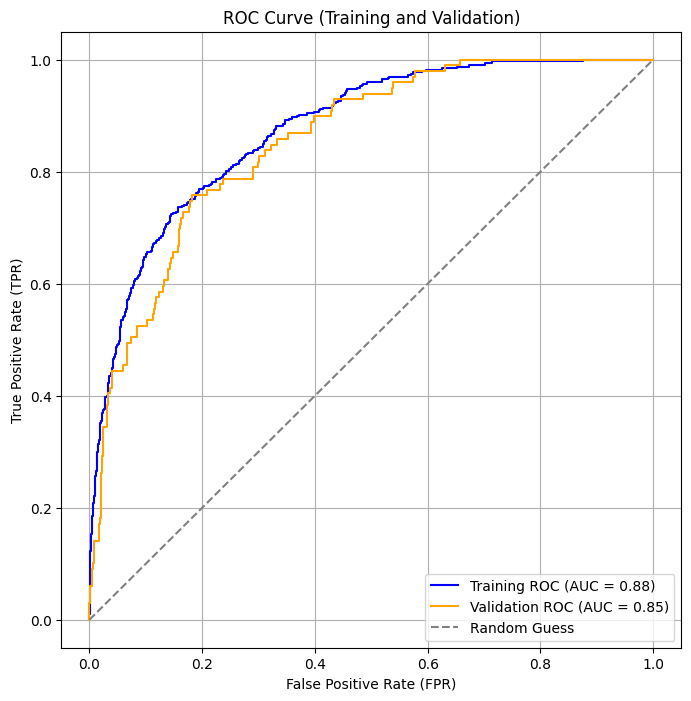

In [230]:
from sklearn.metrics import roc_curve, roc_auc_score

def ensemble_predict(models, X):
    preds = np.zeros(X.shape[0])
    for model in models:
        preds += model.predict_proba(X)[:, 1]  # 各モデルの予測確率を加算
    preds /= len(models)  # 平均化
    return preds

# アンサンブル予測の実行
ensemble_preds_tr1 = ensemble_predict(models1, x_tr)
ensemble_preds_tr2 = ensemble_predict(models2, x_tr)
ensemble_preds_tr3 = ensemble_predict(models3, x_tr)
ensemble_preds_tr = (ensemble_preds_tr1 + ensemble_preds_tr2 + ensemble_preds_tr3) / 3

ensemble_preds_va1 = ensemble_predict(models1, x_va)
ensemble_preds_va2 = ensemble_predict(models2, x_va)
ensemble_preds_va3 = ensemble_predict(models3, x_va)
ensemble_preds_va = (ensemble_preds_va1 + ensemble_preds_va2 + ensemble_preds_va3) / 3

fpr_tr, tpr_tr, _ = roc_curve(y_tr, ensemble_preds_tr)
auc_tr = roc_auc_score(y_tr, ensemble_preds_tr)

fpr_va, tpr_va, _ = roc_curve(y_va, ensemble_preds_va)
auc_va = roc_auc_score(y_va, ensemble_preds_va)

plt.figure(figsize=(8, 8))
plt.plot(fpr_tr, tpr_tr, label=f'Training ROC (AUC = {auc_tr:.2f})', color='blue')
plt.plot(fpr_va, tpr_va, label=f'Validation ROC (AUC = {auc_va:.2f})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Training and Validation)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

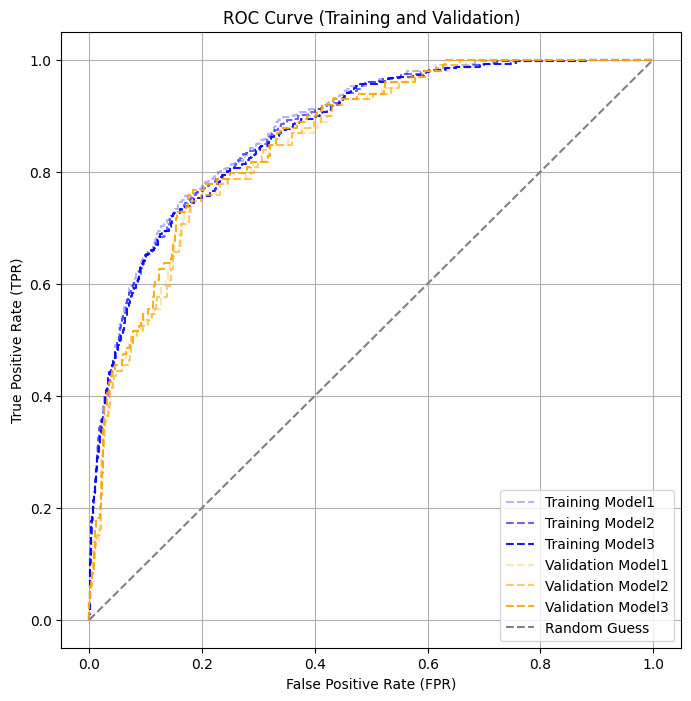

In [231]:
from matplotlib import colors as mcolors

# 色を明るさで区別する (ブルー系とオレンジ系)
blue_shades = [mcolors.to_rgba('blue', alpha) for alpha in [0.3, 0.6, 0.9]]
orange_shades = [mcolors.to_rgba('orange', alpha) for alpha in [0.3, 0.6, 0.9]]

# 個別モデルのROC曲線を計算
fpr_tr1, tpr_tr1, _ = roc_curve(y_tr, ensemble_preds_tr1)
fpr_tr2, tpr_tr2, _ = roc_curve(y_tr, ensemble_preds_tr2)
fpr_tr3, tpr_tr3, _ = roc_curve(y_tr, ensemble_preds_tr3)

fpr_va1, tpr_va1, _ = roc_curve(y_va, ensemble_preds_va1)
fpr_va2, tpr_va2, _ = roc_curve(y_va, ensemble_preds_va2)
fpr_va3, tpr_va3, _ = roc_curve(y_va, ensemble_preds_va3)

# プロット
plt.figure(figsize=(8, 8))

# アンサンブルのROC曲線 (基準の濃い色)
# plt.plot(fpr_tr, tpr_tr, label=f'Training Ensemble (AUC = {auc_tr:.2f})', color='blue', linewidth=2)
# plt.plot(fpr_va, tpr_va, label=f'Validation Ensemble (AUC = {auc_va:.2f})', color='orange', linewidth=2)

# 個別モデルのROC曲線 (明るさで区別)
plt.plot(fpr_tr1, tpr_tr1, linestyle='--', color=blue_shades[0], label='Training Model1')
plt.plot(fpr_tr2, tpr_tr2, linestyle='--', color=blue_shades[1], label='Training Model2')
plt.plot(fpr_tr3, tpr_tr3, linestyle='--', color=blue_shades[2], label='Training Model3')
plt.plot(fpr_va1, tpr_va1, linestyle='--', color=orange_shades[0], label='Validation Model1')
plt.plot(fpr_va2, tpr_va2, linestyle='--', color=orange_shades[1], label='Validation Model2')
plt.plot(fpr_va3, tpr_va3, linestyle='--', color=orange_shades[2], label='Validation Model3')

# 基準線
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# グラフ設定
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Training and Validation)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


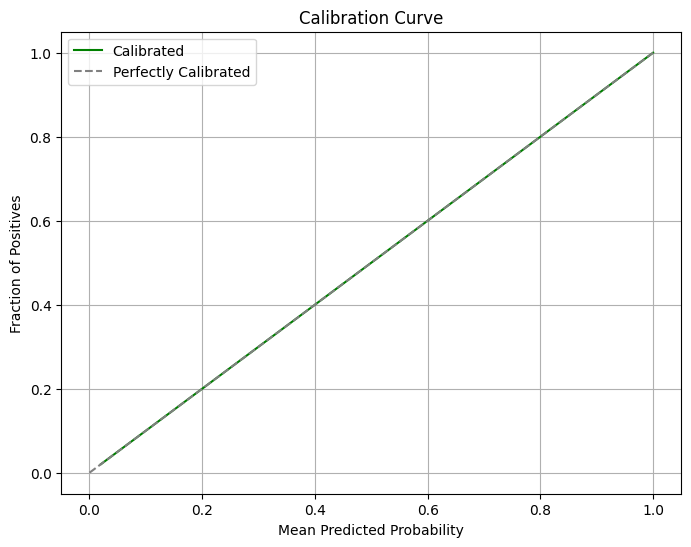

In [232]:
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve

# Isotonic Regressionでキャリブレーション
iso_reg = IsotonicRegression(out_of_bounds='clip')
calibrated_preds_va = iso_reg.fit_transform(ensemble_preds_va, y_va)

# キャリブレーション曲線をプロット
prob_true, prob_pred = calibration_curve(y_va, calibrated_preds_va, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, label="Calibrated", color="green")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly Calibrated", color="gray")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.grid()
plt.show()

In [233]:
import numpy as np

# 各モデルの予測値
predictions = [ensemble_preds_va1, ensemble_preds_va2, ensemble_preds_va3]

# モデル間の相関行列を計算
correlation_matrix = np.corrcoef(predictions)

print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
[[1.         0.99785076 0.99600576]
 [0.99785076 1.         0.99703448]
 [0.99600576 0.99703448 1.        ]]


In [234]:
# 重み付きアンサンブル
weights = [0.4, 0.3, 0.3]  # 各モデルの重要性に基づく重み
ensemble_preds_tr_weighted = (weights[0] * ensemble_preds_tr1 +
                              weights[1] * ensemble_preds_tr2 +
                              weights[2] * ensemble_preds_tr3)

ensemble_preds_va_weighted = (weights[0] * ensemble_preds_va1 +
                              weights[1] * ensemble_preds_va2 +
                              weights[2] * ensemble_preds_va3)

# ROC AUC の再計算
auc_tr_weighted = roc_auc_score(y_tr, ensemble_preds_tr_weighted)
auc_va_weighted = roc_auc_score(y_va, ensemble_preds_va_weighted)

print(f"Weighted AUC (Training): {auc_tr_weighted:.4f}")
print(f"Weighted AUC (Validation): {auc_va_weighted:.4f}")

Weighted AUC (Training): 0.8759
Weighted AUC (Validation): 0.8546


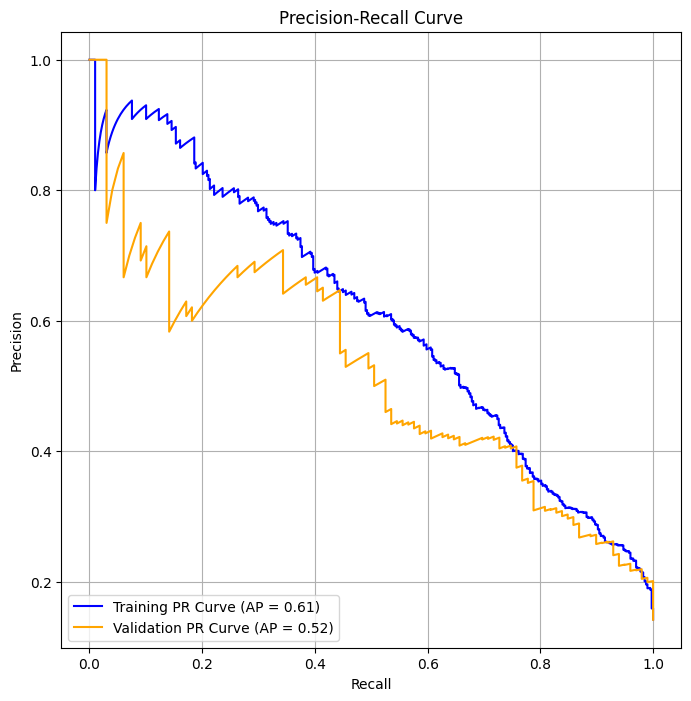

In [235]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall曲線
precision_tr, recall_tr, _ = precision_recall_curve(y_tr, ensemble_preds_tr)
precision_va, recall_va, _ = precision_recall_curve(y_va, ensemble_preds_va)

ap_tr = average_precision_score(y_tr, ensemble_preds_tr)
ap_va = average_precision_score(y_va, ensemble_preds_va)

# プロット
plt.figure(figsize=(8, 8))
plt.plot(recall_tr, precision_tr, label=f'Training PR Curve (AP = {ap_tr:.2f})', color='blue')
plt.plot(recall_va, precision_va, label=f'Validation PR Curve (AP = {ap_va:.2f})', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [239]:
# y_pred_prob = model.predict_proba(test_df[features])[:, 1]
y_pred_prob1 = ensemble_predict(models1, x_test)
y_pred_prob2 = ensemble_predict(models2, x_test)
y_pred_prob3 = ensemble_predict(models3, x_test)
y_pred_prob = (y_pred_prob1 + y_pred_prob2 + y_pred_prob3) / 3

# 1. キャリブレーションモデルの学習
iso_reg = IsotonicRegression(out_of_bounds='clip')
iso_reg.fit(ensemble_preds_va, y_va)  # バリデーションデータで学習

# 2. テストデータの予測確率をキャリブレーション
calibrated_test_preds = iso_reg.transform(y_pred_prob)  # テストデータを補正

y_pred_prob = (y_pred_prob + calibrated_test_preds) / 2

sub = pd.read_csv('/content/drive/MyDrive/契約予測（SIGNATE Cup 2024）/提供データ/sample_submit.csv', header=None)
test_ids = sub.iloc[:, 0]

submission = pd.DataFrame({
    'id': test_ids,
    'prob': y_pred_prob
})

submission_name = "prodtaken_submission27"

submission.to_csv(f'{submission_name}.csv', index=False, header=None)
submission.head(10)

,id,prob
0,3489,0.073902
1,3490,0.240658
2,3491,0.248425
3,3492,0.260696
4,3493,0.409454
5,3494,0.028801
6,3495,0.286145
7,3496,0.071374
8,3497,0.413278
9,3498,0.466917
